### 0. IMPORTS

In [127]:
import math
import numpy  as np
import pandas as pd
import inflection
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats as ss
import datetime
import calendar
from tabulate import tabulate

#### 0.1. Helper Functions

In [142]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [132]:
jupyter_settings()

#### 0.2. Loading data

In [133]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

### 1. Descrição dos Dados

In [5]:
df1 = df_raw.copy()

#### 1.1. Rename Columns

In [6]:
old_cols = df1.columns.to_list()

snakecase = lambda x: inflection.underscore( x )

# rename
df1.columns = list( map( snakecase, old_cols ) )

#### 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


#### 1.3. Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )

#### 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### 1.5. Fillout NA

In [11]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
847642,1028,7,2013-06-02,0,0,0,0,0,0,a,a,150.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
209842,223,6,2015-01-24,5681,616,1,0,0,0,d,c,2920.0,10.0,1995.0,1,27.0,2011.0,"Jan,Apr,Jul,Oct"
354796,731,3,2014-08-27,6795,815,1,0,0,0,a,a,15270.0,NaN,NaN,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
841339,300,5,2013-06-07,6689,835,1,1,0,0,a,c,120.0,4.0,2009.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
19200,246,2,2015-07-14,9651,1073,1,1,0,0,c,a,4660.0,4.0,2013.0,0,NaN,NaN,NaN


In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

#### 1.6. Change Data Types

In [15]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

#### 1.7. Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

##### 1.7.1. Numerical Atributes

In [18]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


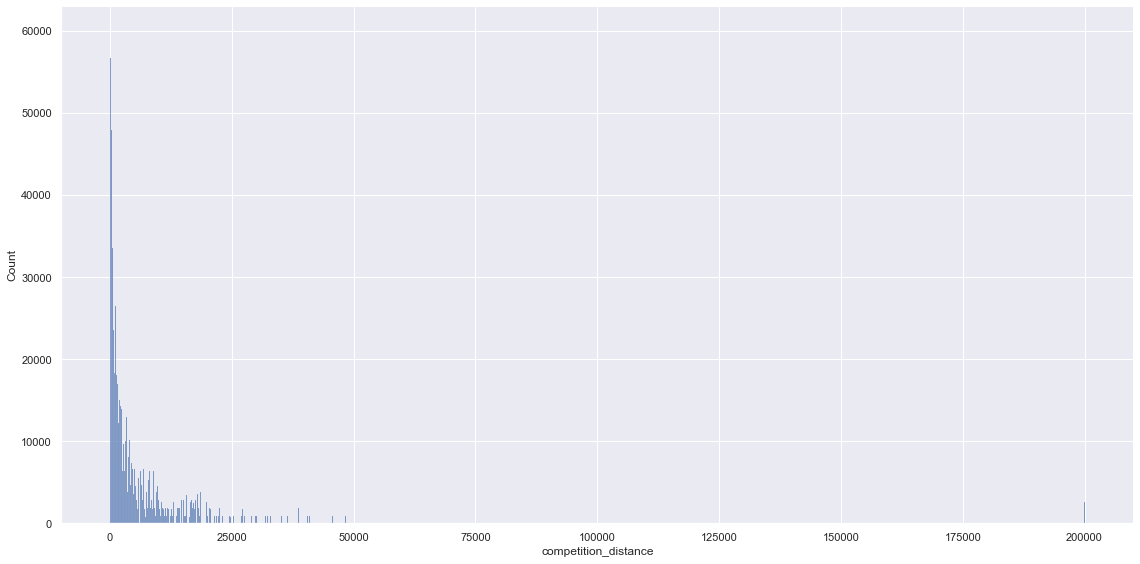

In [19]:
sns.displot( df1['competition_distance'], kind='hist', height=8, aspect=2);

##### 1.7.2. Categorical Atributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

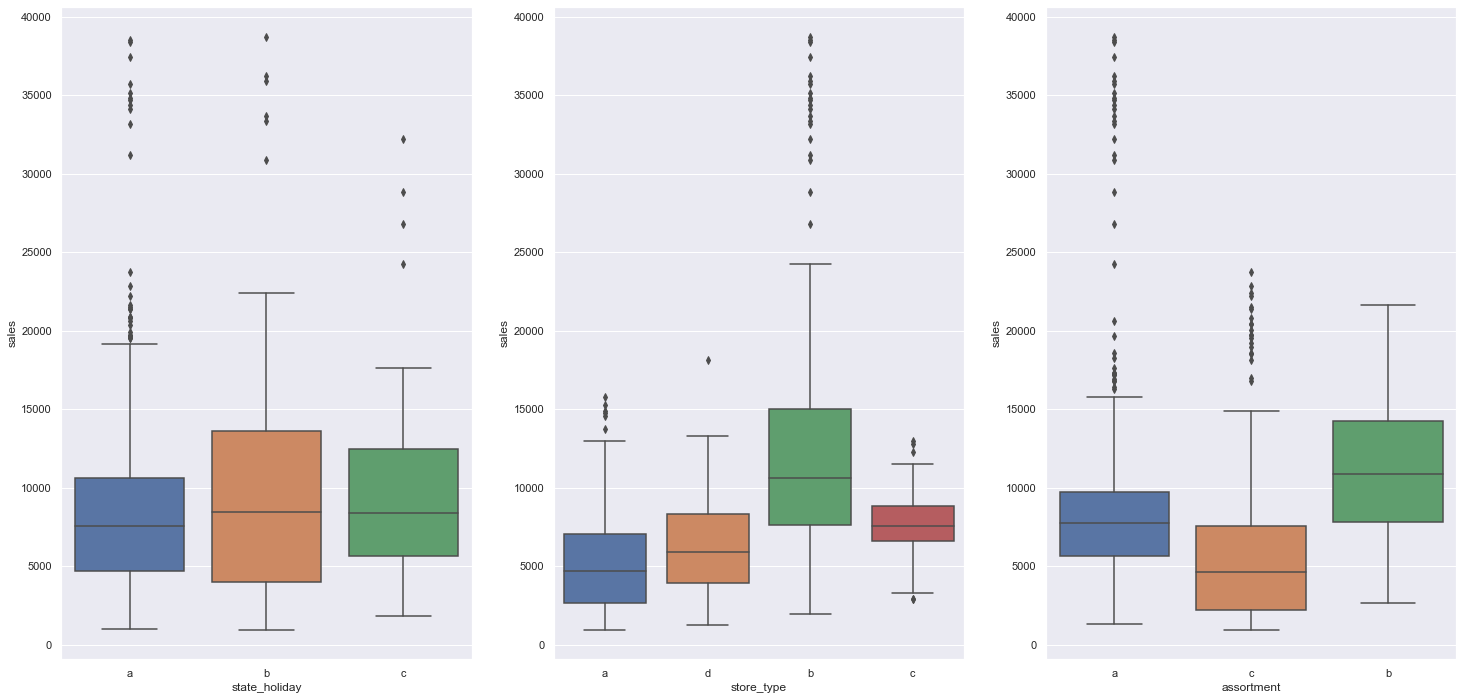

In [21]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

### 2. Feature Engineering

In [22]:
df2 = df1.copy()

#### 2.1. Mapa Mental de Hipoteses

#### 2.2. Criacao das Hipoteses

##### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

##### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

##### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

#### 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


#### 2.4. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

### 3. Filtragem de Variáveis

In [24]:
df3 = df2.copy()

#### 3.1. Filtragem das Linhas


In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

#### 3.2. Selecao das Colunas

In [26]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [27]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 4. Análise Exploratória de Dados

In [ ]:
df4 = df3.copy()

In [ ]:
df4.sample(20)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
777529,45,6,2013-08-03,5536,0,regular_day,0,d,basic,9710.0,2,2014,0,31,2013,0,2013,8,3,31,2013-30,2014-02-01,-7,2013-07-29,0
786073,784,6,2013-07-27,4790,0,regular_day,0,a,basic,560.0,10,2014,1,10,2014,1,2013,7,27,30,2013-29,2014-10-01,-15,2014-03-03,-32
734107,108,3,2013-09-11,11309,1,regular_day,1,d,extended,2190.0,9,2003,0,37,2013,0,2013,9,11,37,2013-36,2003-09-01,122,2013-09-09,0
986502,513,1,2013-01-28,16286,0,regular_day,0,a,basic,400.0,8,2013,0,5,2013,0,2013,1,28,5,2013-04,2013-08-01,-7,2013-01-28,0
997862,723,5,2013-01-18,3680,0,regular_day,0,d,extended,5650.0,9,2008,1,5,2013,0,2013,1,18,3,2013-02,2008-09-01,53,2013-01-28,-2
404991,373,5,2014-07-04,4393,1,regular_day,0,d,extended,11120.0,7,2014,1,22,2012,1,2014,7,4,27,2014-26,2014-07-01,0,2012-05-21,110
588856,922,1,2014-01-20,10823,1,regular_day,0,d,basic,2110.0,3,2006,0,4,2014,0,2014,1,20,4,2014-03,2006-03-01,96,2014-01-20,0
871642,498,6,2013-05-11,7689,0,regular_day,0,a,basic,990.0,5,2013,1,40,2014,0,2013,5,11,19,2013-18,2013-05-01,0,2014-09-29,-73
559915,971,6,2014-02-15,7981,0,regular_day,0,c,basic,1140.0,5,2011,1,14,2012,0,2014,2,15,7,2014-06,2011-05-01,34,2012-03-26,98
101116,767,6,2015-05-02,4800,0,regular_day,0,a,extended,13080.0,5,2015,0,18,2015,0,2015,5,2,18,2015-17,2015-05-01,0,2015-04-27,0


#### 4.1 Análise Univariada

##### 4.1.1 Variável Resposta

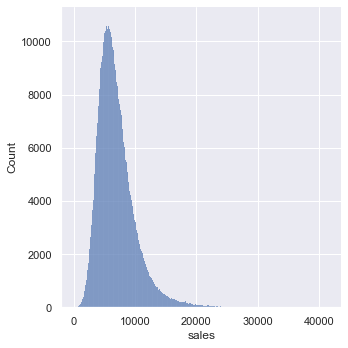

In [ ]:
sns.displot(df4.sales)

##### 4.1.2 Variáveis Numéricas

In [ ]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

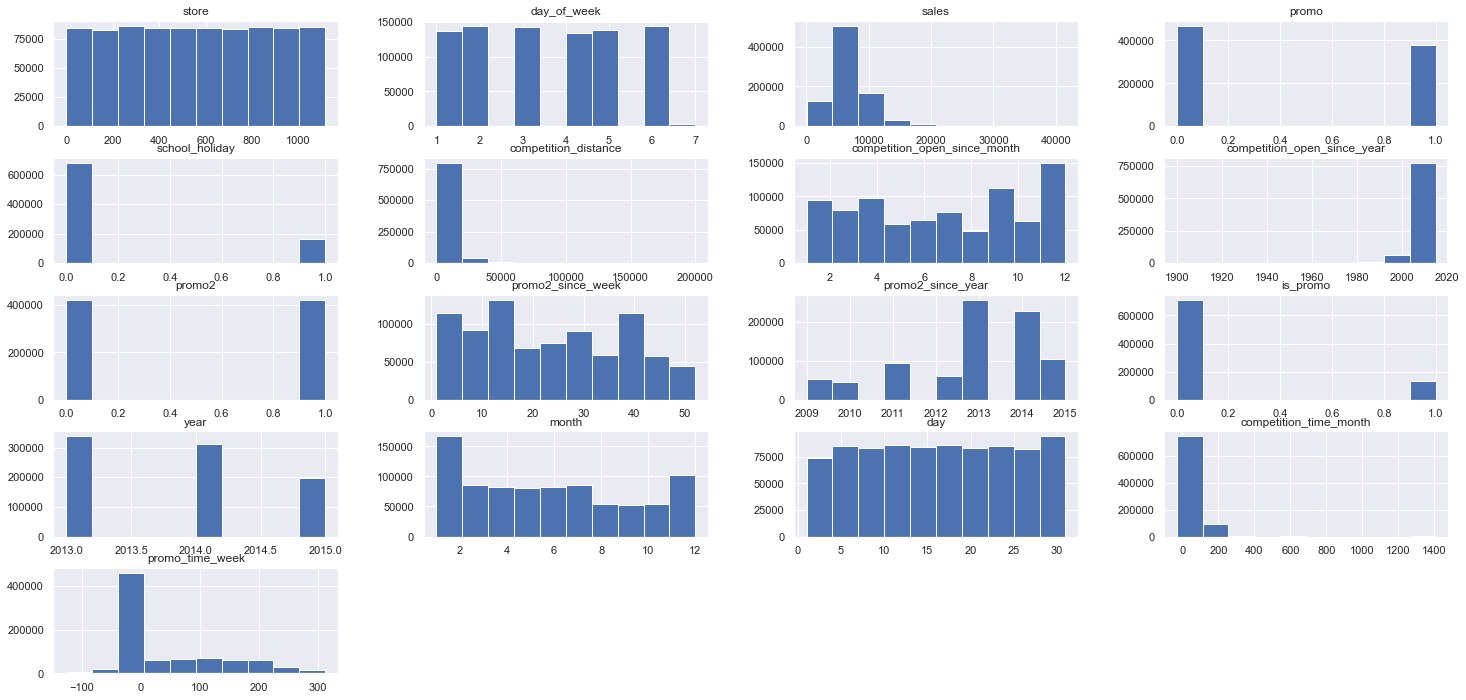

In [ ]:
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float64'])
num_attributes.hist();

##### 4.1.3 Variáveis Categóricas

c:\Users\renat\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\renat\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\renat\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

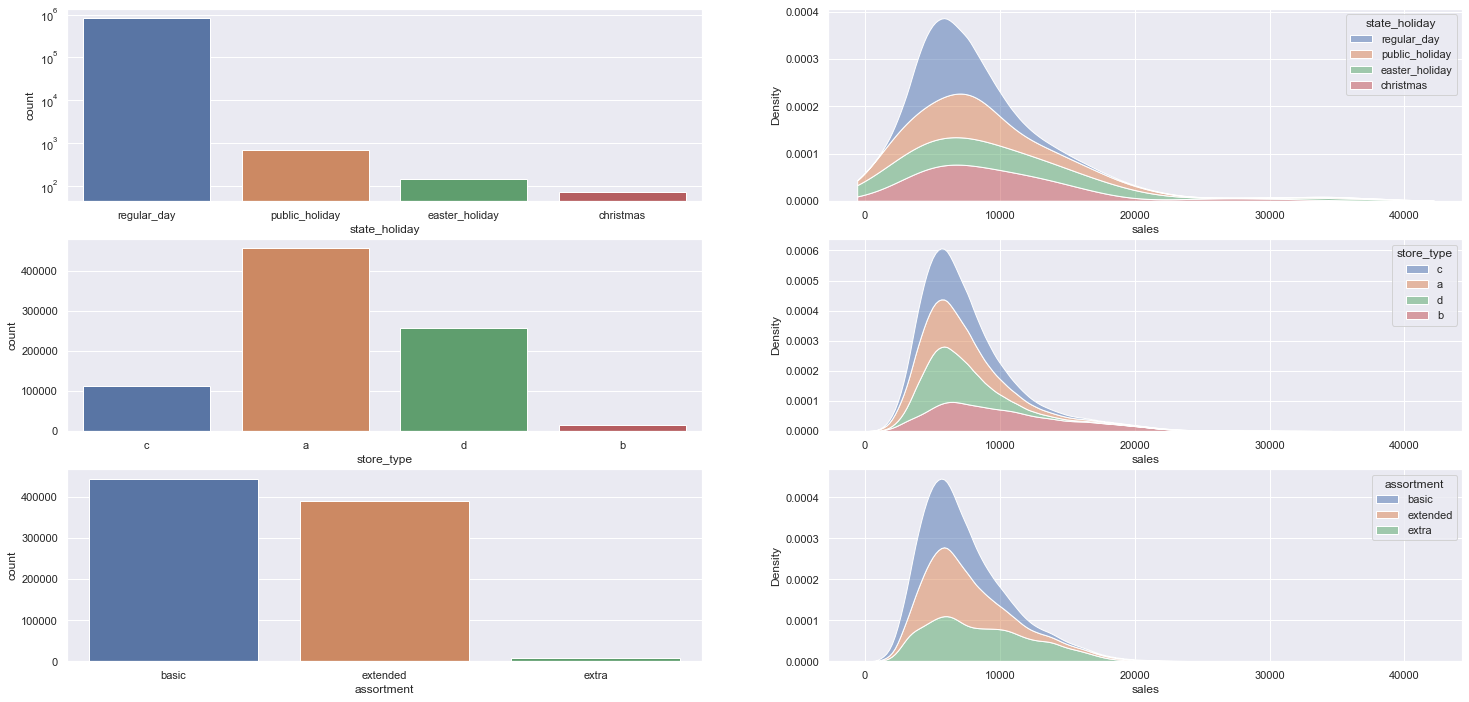

In [ ]:
plt.subplot(3,2,1)
sns.countplot(df4.state_holiday, log=True);

plt.subplot(3,2,2)
sns.kdeplot( data=df4, x='sales', hue='state_holiday', common_norm=False, multiple='stack', alpha=0.5, fill=True);

plt.subplot(3,2,3)
sns.countplot(df4.store_type);

plt.subplot(3,2,4)
sns.kdeplot( data=df4, x='sales', hue='store_type', common_norm=False, multiple='stack', alpha=0.5, fill=True);

plt.subplot(3,2,5)
sns.countplot(df4.assortment);

plt.subplot(3,2,6)
sns.kdeplot( data=df4, x='sales', hue='assortment', common_norm=False, multiple='stack', alpha=0.5, fill=True);

#### 4.2 Análise Bivariada


**H1.** Lojas com maior sortimentos deveriam vender mais.


<AxesSubplot:xlabel='year_week'>

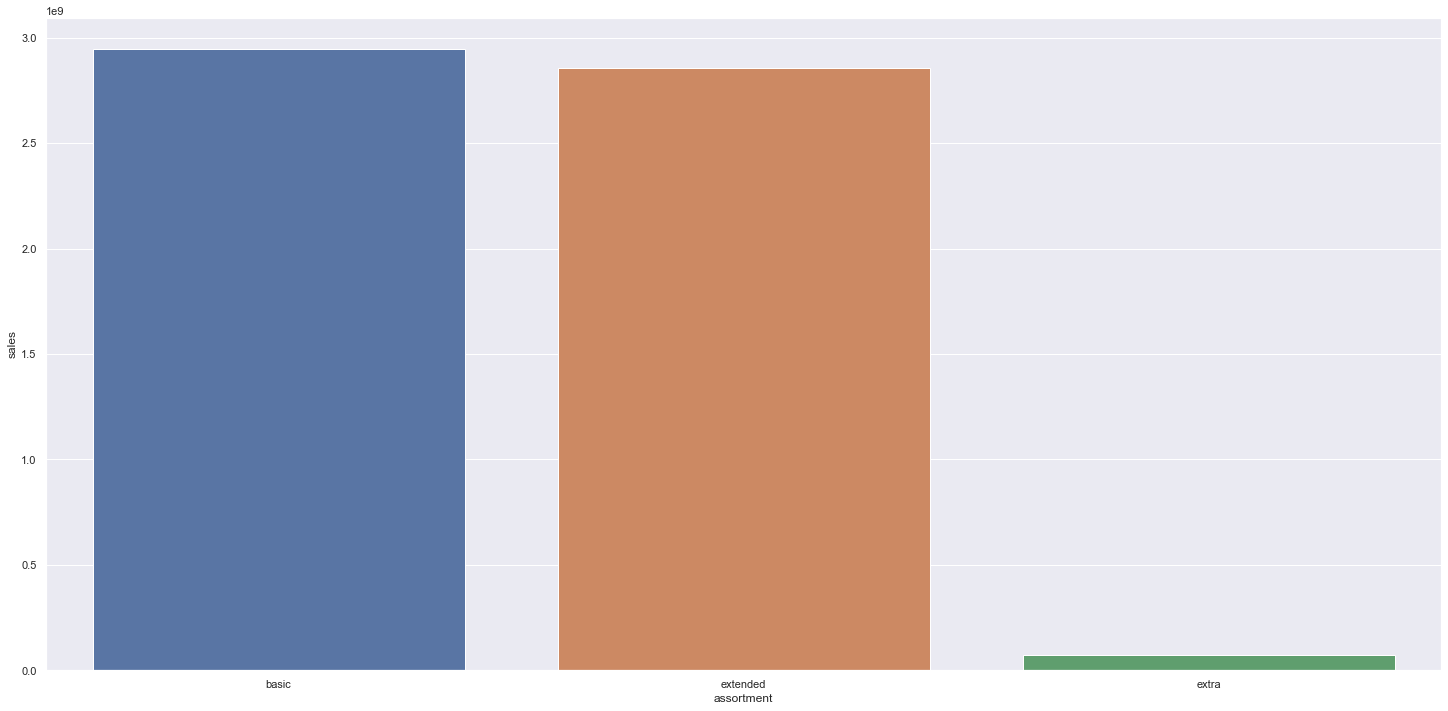

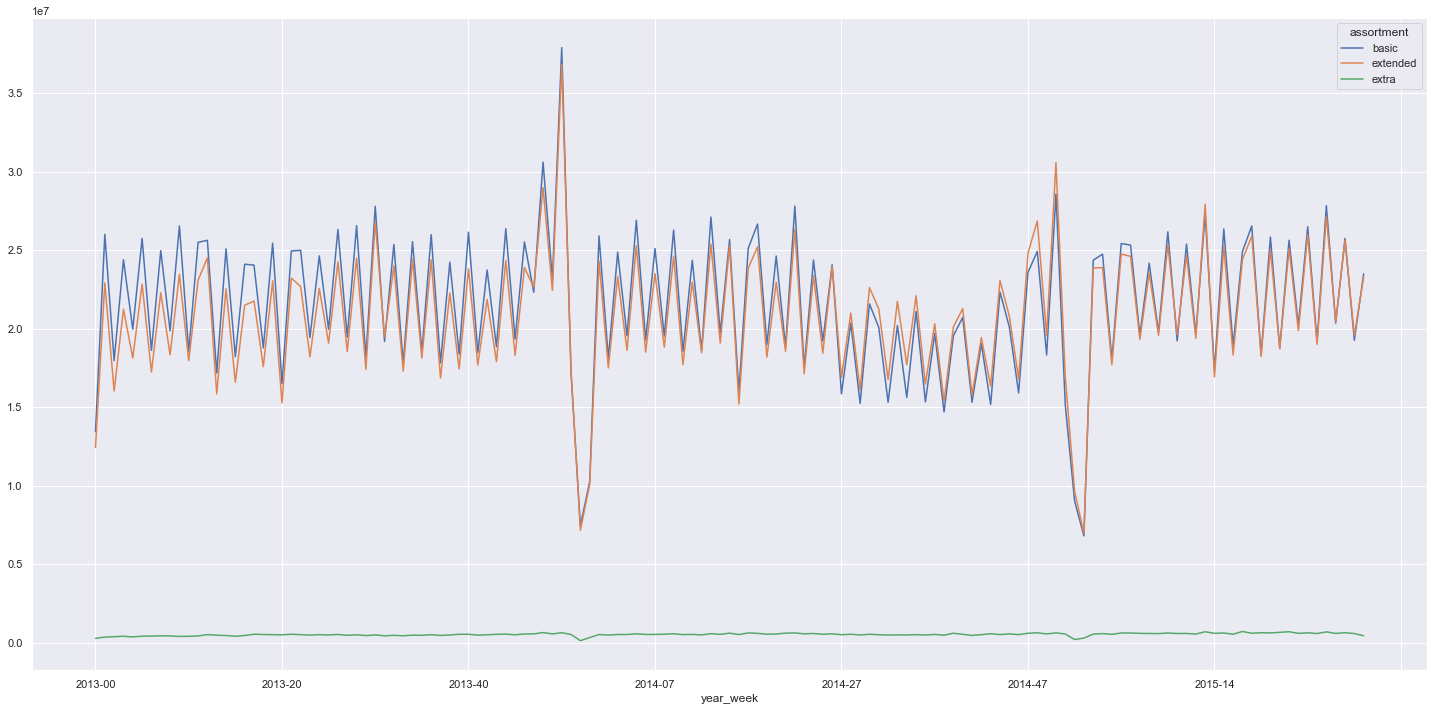

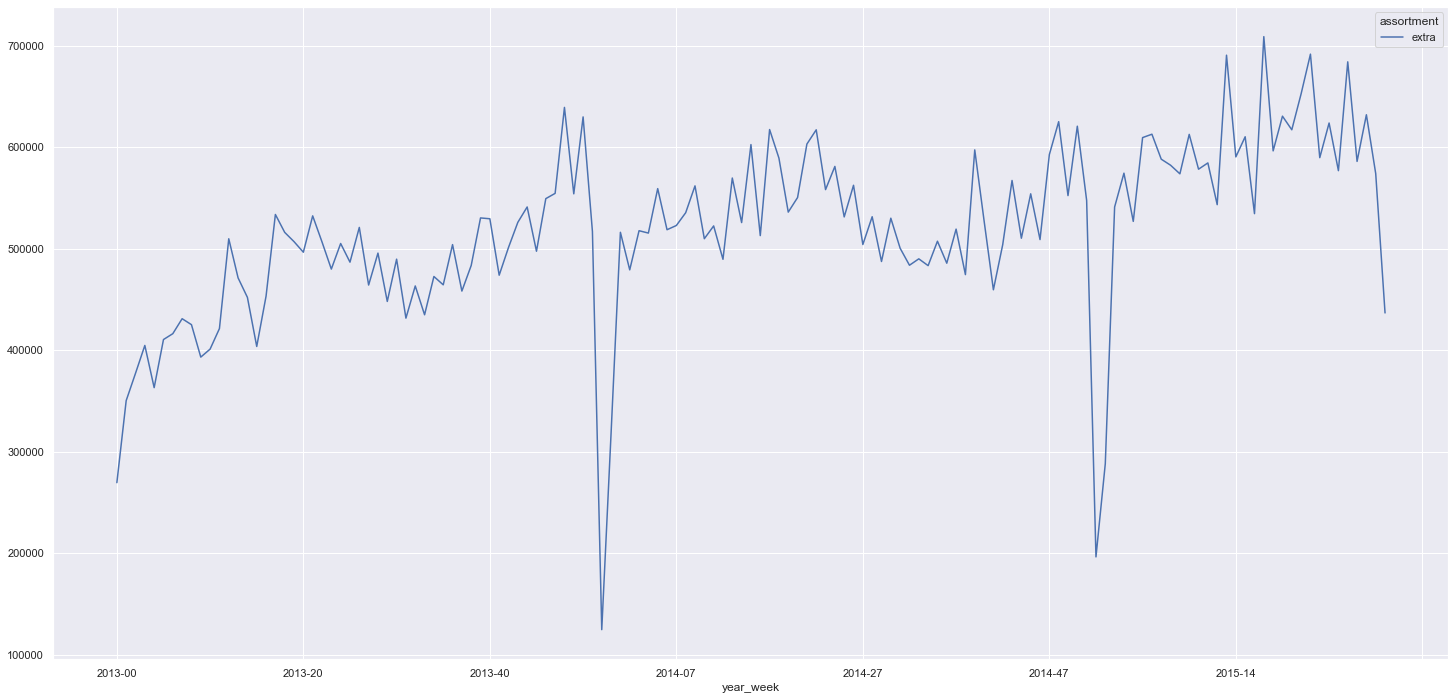

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)
aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


**H2.** Lojas com competidores mais próximos deveriam vender menos.

<AxesSubplot:>

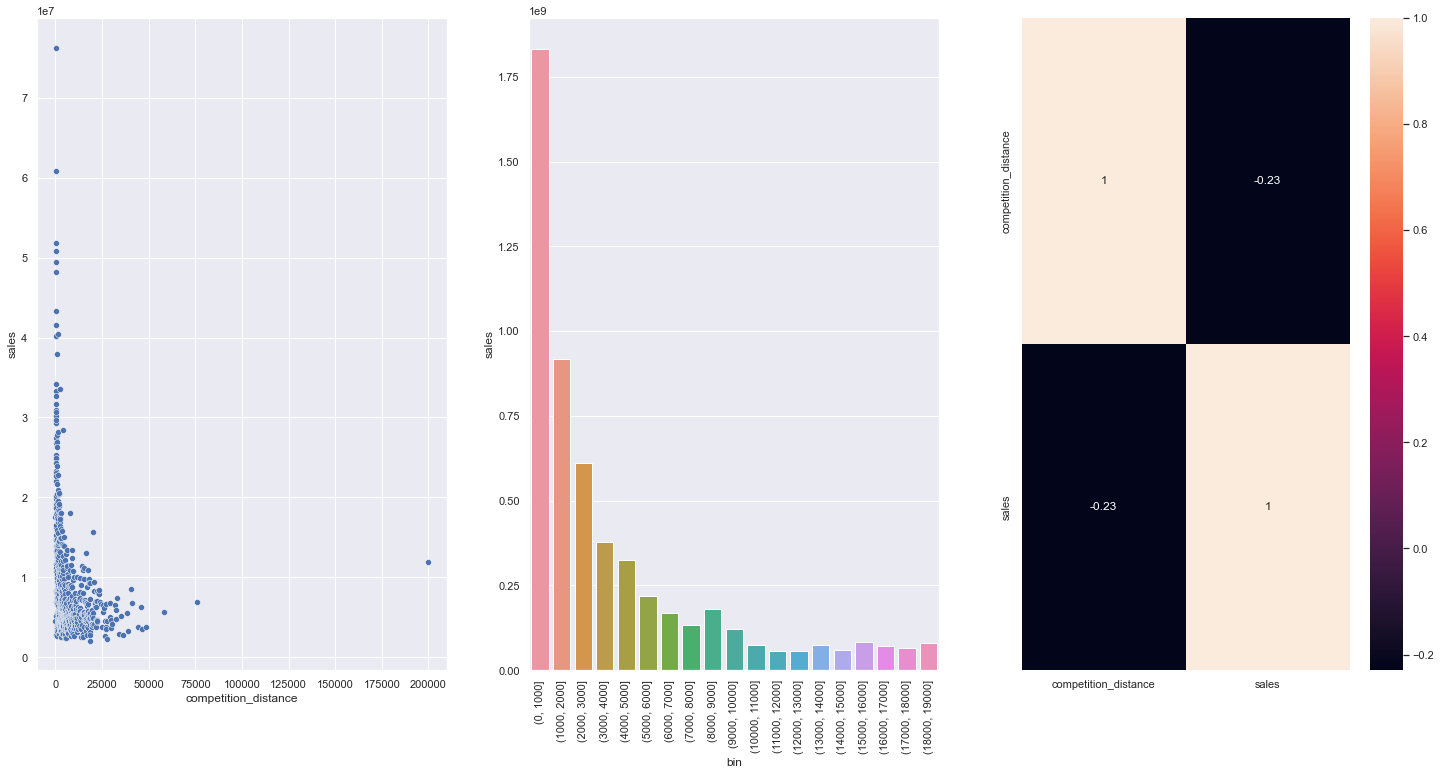

In [ ]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = np.arange(0, 20000, 1000)
aux1['bin'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['bin', 'sales']].groupby('bin').sum().reset_index()
sns.barplot(x='bin', y='sales', data=aux2,)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(data=aux1.corr(method='pearson'), annot=True)


**H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

In [ ]:
df4[['store', 'sales', 'state_holiday']].head(10)

,store,sales,state_holiday
0,1,5263,regular_day
1,2,6064,regular_day
2,3,8314,regular_day
3,4,13995,regular_day
4,5,4822,regular_day
5,6,5651,regular_day
6,7,15344,regular_day
7,8,8492,regular_day
8,9,8565,regular_day
9,10,7185,regular_day


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

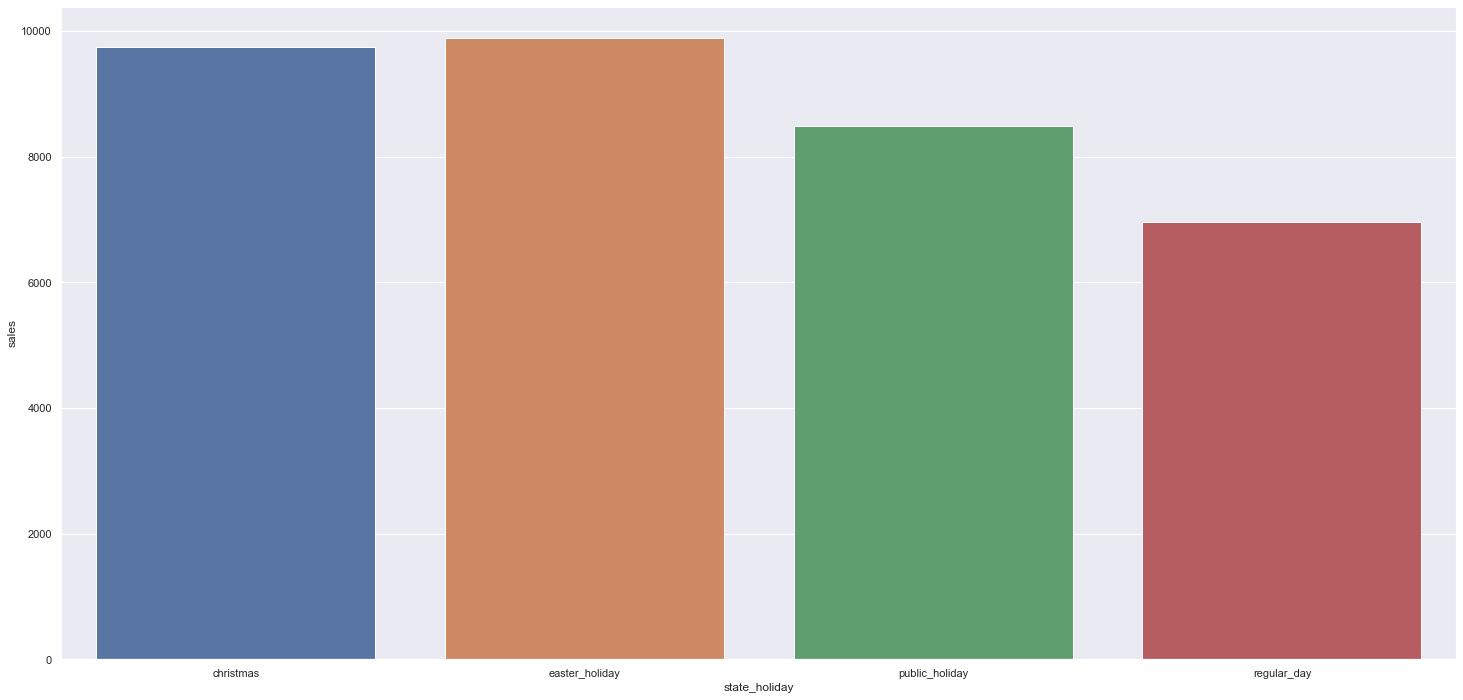

In [ ]:
aux1 = df4[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 )

**9.** Lojas deveriam vender mais ao longo dos anos.

In [ ]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

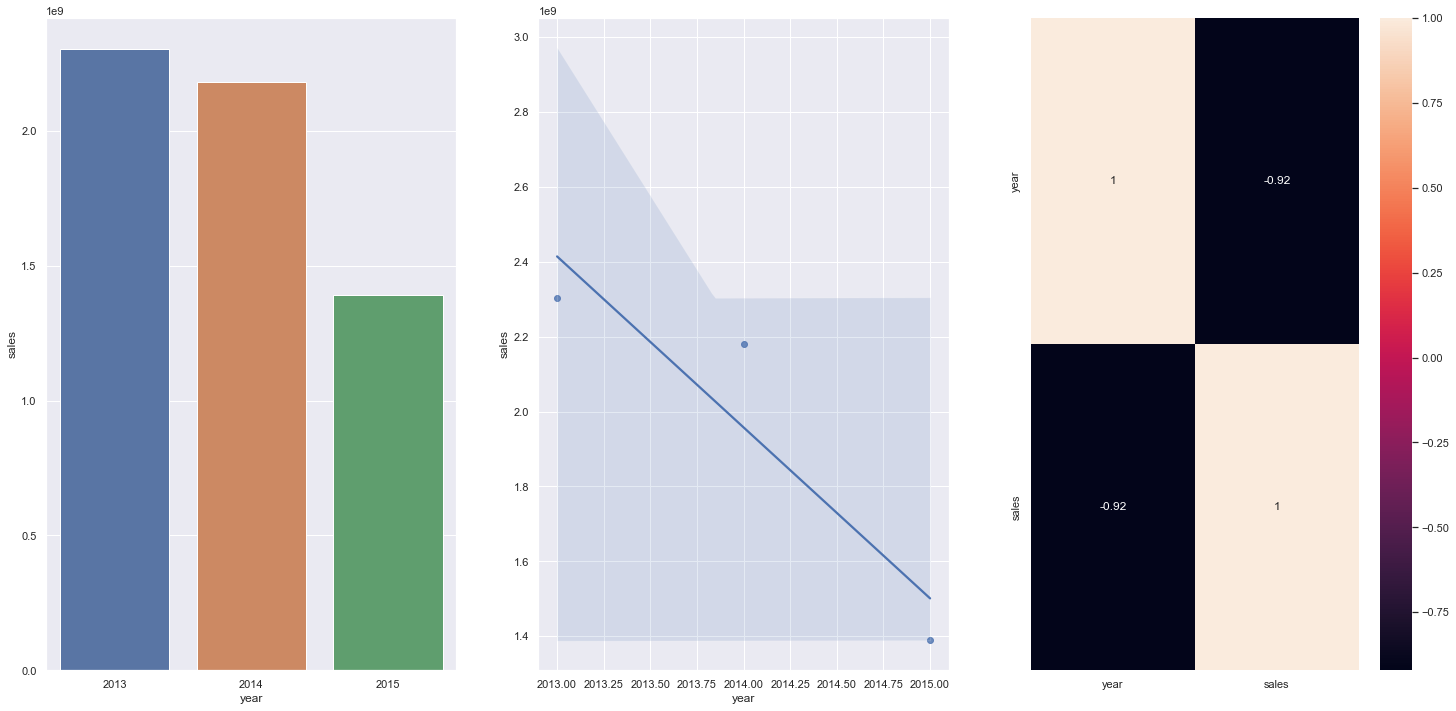

In [ ]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**10.** Lojas deveriam vender mais no segundo semestre do ano.

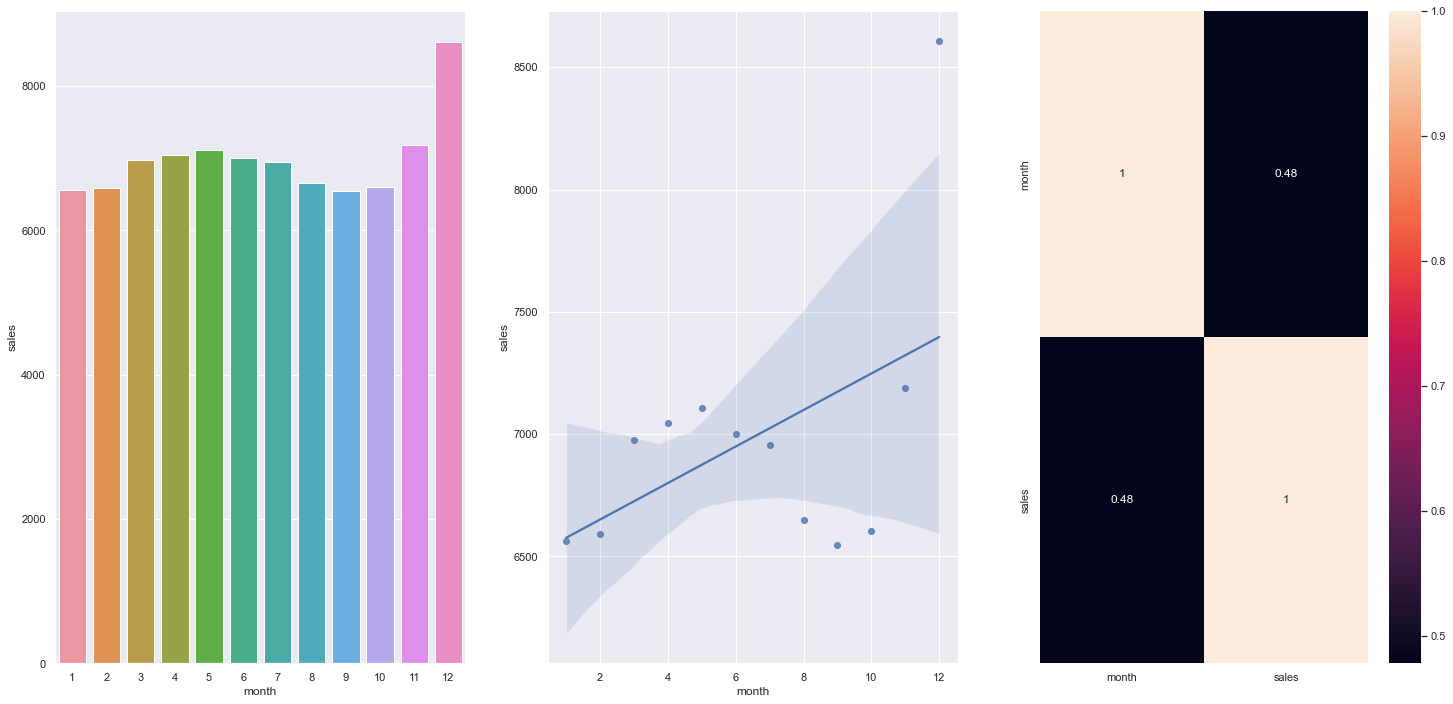

In [ ]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

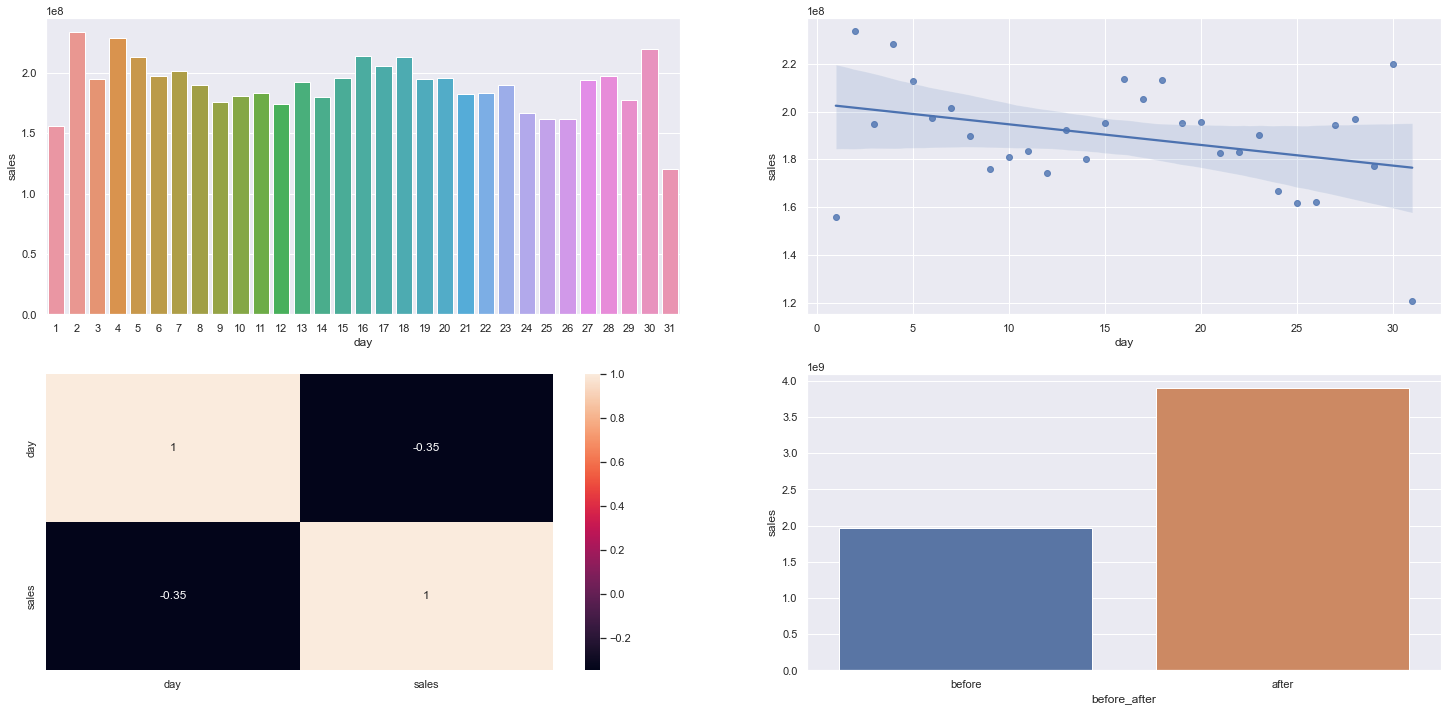

In [ ]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
aux1 = aux1.assign(before_after=lambda x: pd.cut(x['day'], bins=[0,10,31], labels=['before', 'after'] ))

aux2 = aux1[['sales', 'before_after']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

**12.** Lojas deveriam vender menos aos finais de semana.

In [ ]:
days = list(calendar.day_name)

i = 1
day_names = {}
while i < 8:
    day_names[i] = days[i-1]
    i = i + 1

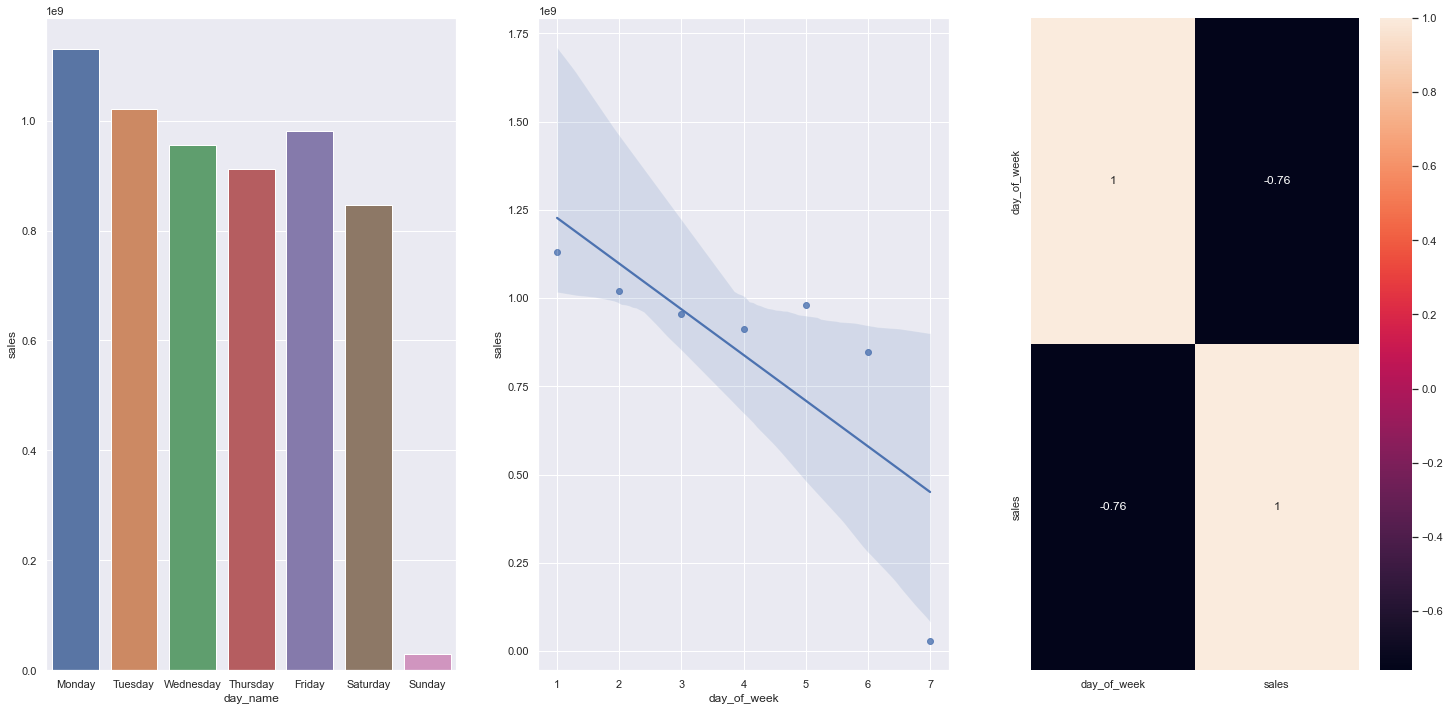

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
aux1['day_name'] = aux1['day_of_week'].map(day_names)
aux2 = aux1 [['day_name', 'sales']]

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_name', y='sales', data=aux2 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**13.** Lojas deveriam vender menos durante os feriados escolares.

<AxesSubplot:xlabel='month', ylabel='sales'>

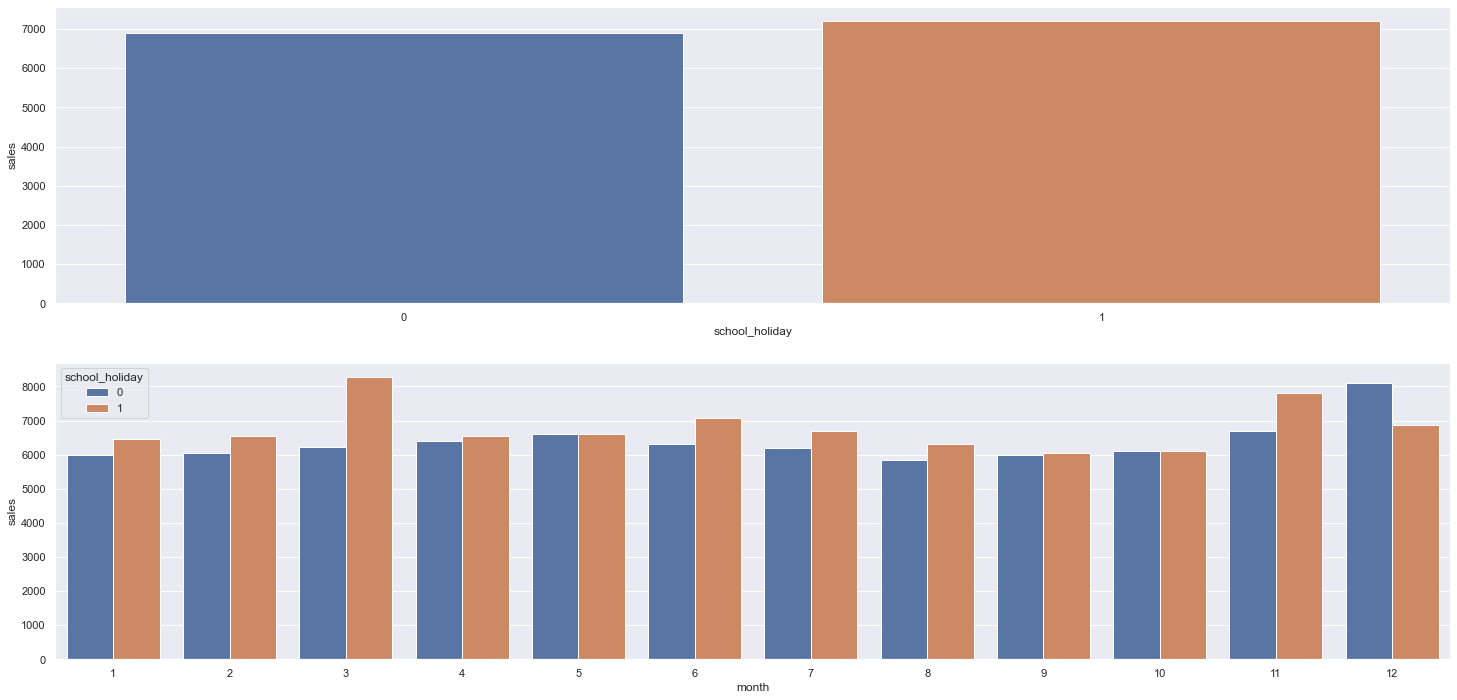

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).median().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


#### 4.3 Análise Multivariada

##### 4.3.1 Variáveis Numéricas

<AxesSubplot:>

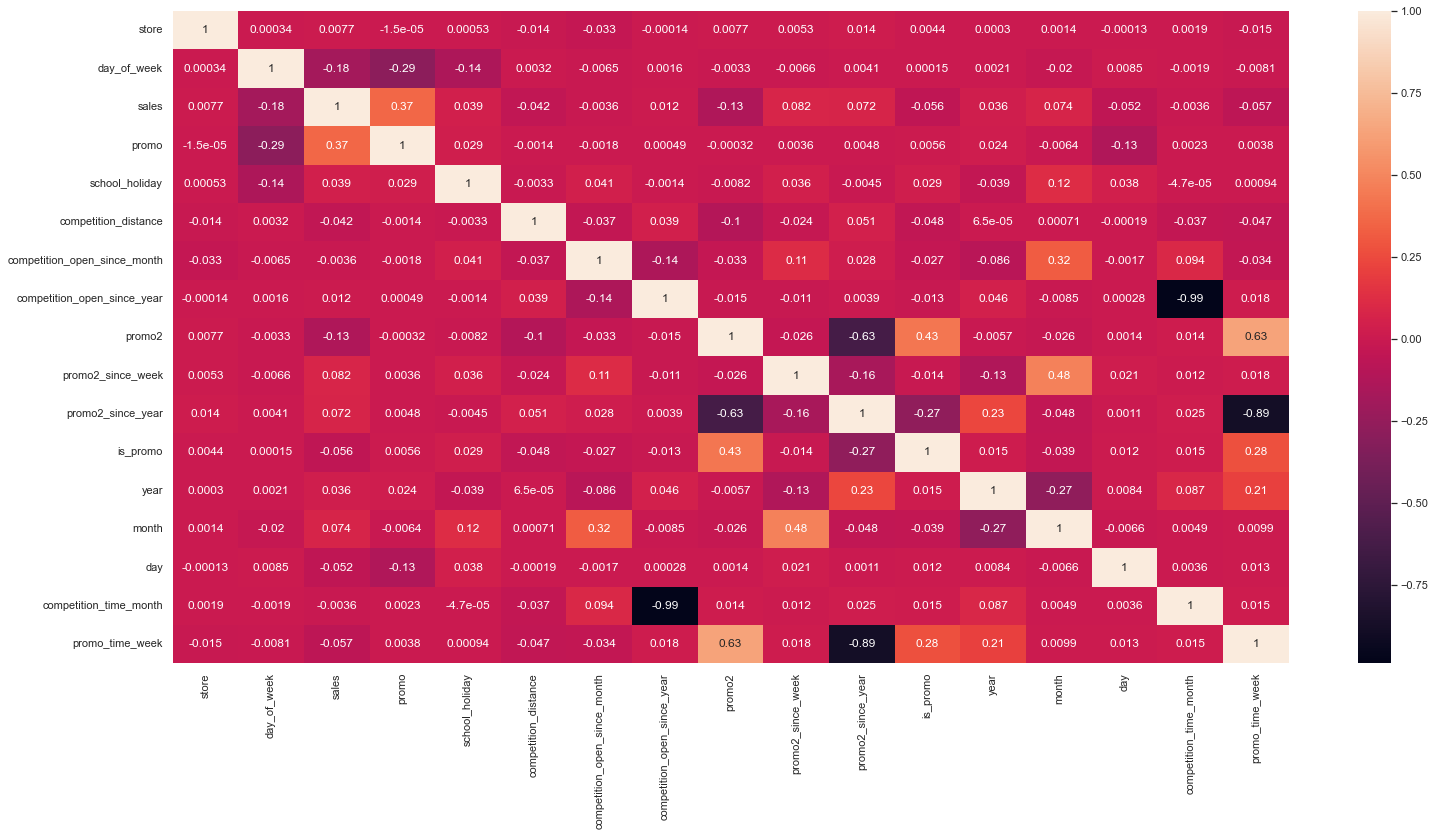

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True)

##### 4.3.2 Variáveis Categóricas

<AxesSubplot:>

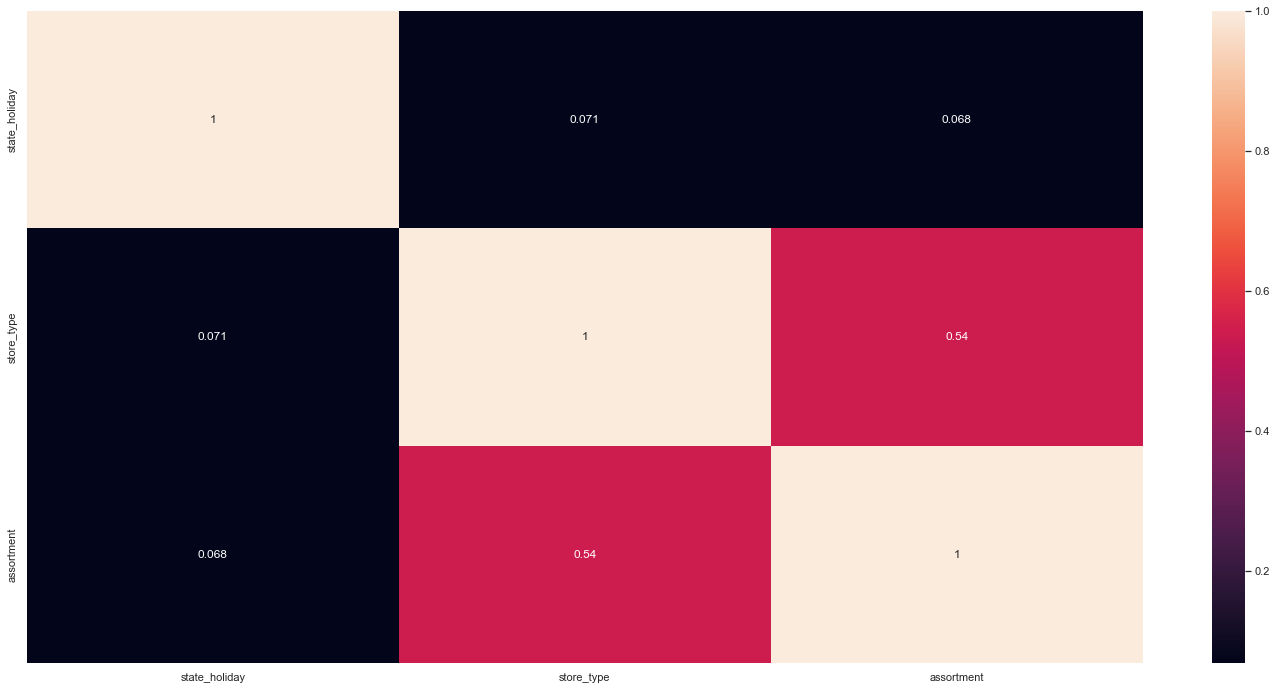

In [ ]:
# only categorical data
cat_attributes = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v( cat_attributes['state_holiday'], cat_attributes['state_holiday'] )
a2 = cramer_v( cat_attributes['state_holiday'], cat_attributes['store_type'] )
a3 = cramer_v( cat_attributes['state_holiday'], cat_attributes['assortment'] )
a4 = cramer_v( cat_attributes['store_type'], cat_attributes['state_holiday'] )
a5 = cramer_v( cat_attributes['store_type'], cat_attributes['store_type'] )
a6 = cramer_v( cat_attributes['store_type'], cat_attributes['assortment'] )
a7 = cramer_v( cat_attributes['assortment'], cat_attributes['state_holiday'] )
a8 = cramer_v( cat_attributes['assortment'], cat_attributes['store_type'] )
a9 = cramer_v( cat_attributes['assortment'], cat_attributes['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

In [28]:
df4 = df3.copy()

In [39]:
df4.sample(20)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
777529,45,6,2013-08-03,5536,0,regular_day,0,d,basic,9710.0,2,2014,0,31,2013,0,2013,8,3,31,2013-30,2014-02-01,-7,2013-07-29,0
786073,784,6,2013-07-27,4790,0,regular_day,0,a,basic,560.0,10,2014,1,10,2014,1,2013,7,27,30,2013-29,2014-10-01,-15,2014-03-03,-32
734107,108,3,2013-09-11,11309,1,regular_day,1,d,extended,2190.0,9,2003,0,37,2013,0,2013,9,11,37,2013-36,2003-09-01,122,2013-09-09,0
986502,513,1,2013-01-28,16286,0,regular_day,0,a,basic,400.0,8,2013,0,5,2013,0,2013,1,28,5,2013-04,2013-08-01,-7,2013-01-28,0
997862,723,5,2013-01-18,3680,0,regular_day,0,d,extended,5650.0,9,2008,1,5,2013,0,2013,1,18,3,2013-02,2008-09-01,53,2013-01-28,-2
404991,373,5,2014-07-04,4393,1,regular_day,0,d,extended,11120.0,7,2014,1,22,2012,1,2014,7,4,27,2014-26,2014-07-01,0,2012-05-21,110
588856,922,1,2014-01-20,10823,1,regular_day,0,d,basic,2110.0,3,2006,0,4,2014,0,2014,1,20,4,2014-03,2006-03-01,96,2014-01-20,0
871642,498,6,2013-05-11,7689,0,regular_day,0,a,basic,990.0,5,2013,1,40,2014,0,2013,5,11,19,2013-18,2013-05-01,0,2014-09-29,-73
559915,971,6,2014-02-15,7981,0,regular_day,0,c,basic,1140.0,5,2011,1,14,2012,0,2014,2,15,7,2014-06,2011-05-01,34,2012-03-26,98
101116,767,6,2015-05-02,4800,0,regular_day,0,a,extended,13080.0,5,2015,0,18,2015,0,2015,5,2,18,2015-17,2015-05-01,0,2015-04-27,0


#### 4.1 Análise Univariada

##### 4.1.1 Variável Resposta

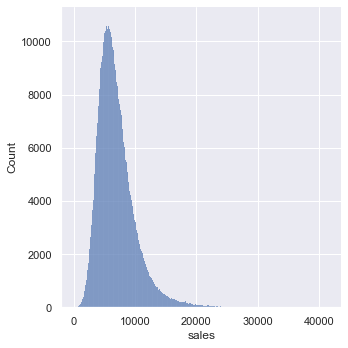

In [29]:
sns.displot(df4.sales)

##### 4.1.2 Variáveis Numéricas

In [30]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

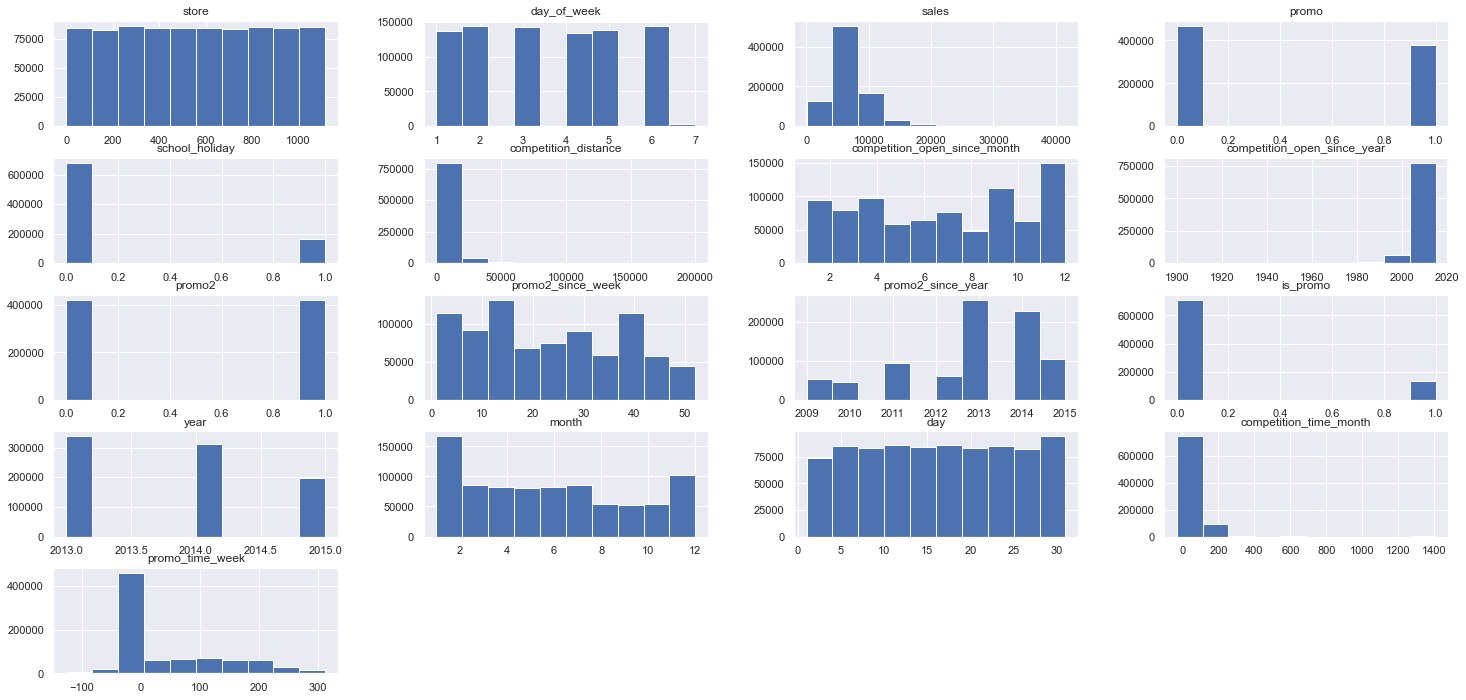

In [31]:
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float64'])
num_attributes.hist();

##### 4.1.3 Variáveis Categóricas

c:\Users\renat\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\renat\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\renat\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

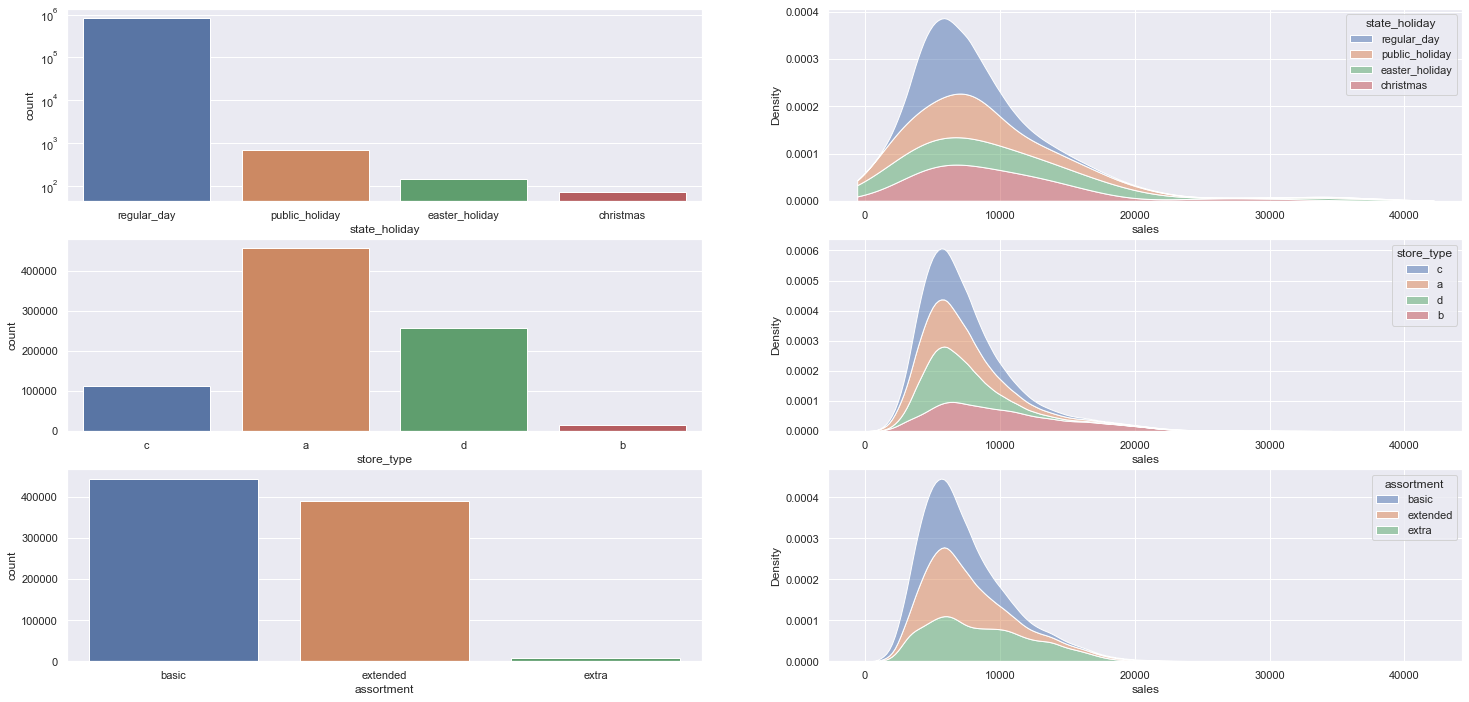

In [32]:
plt.subplot(3,2,1)
sns.countplot(df4.state_holiday, log=True);

plt.subplot(3,2,2)
sns.kdeplot( data=df4, x='sales', hue='state_holiday', common_norm=False, multiple='stack', alpha=0.5, fill=True);

plt.subplot(3,2,3)
sns.countplot(df4.store_type);

plt.subplot(3,2,4)
sns.kdeplot( data=df4, x='sales', hue='store_type', common_norm=False, multiple='stack', alpha=0.5, fill=True);

plt.subplot(3,2,5)
sns.countplot(df4.assortment);

plt.subplot(3,2,6)
sns.kdeplot( data=df4, x='sales', hue='assortment', common_norm=False, multiple='stack', alpha=0.5, fill=True);

#### 4.2 Análise Bivariada


**H1.** Lojas com maior sortimentos deveriam vender mais.


<AxesSubplot:xlabel='year_week'>

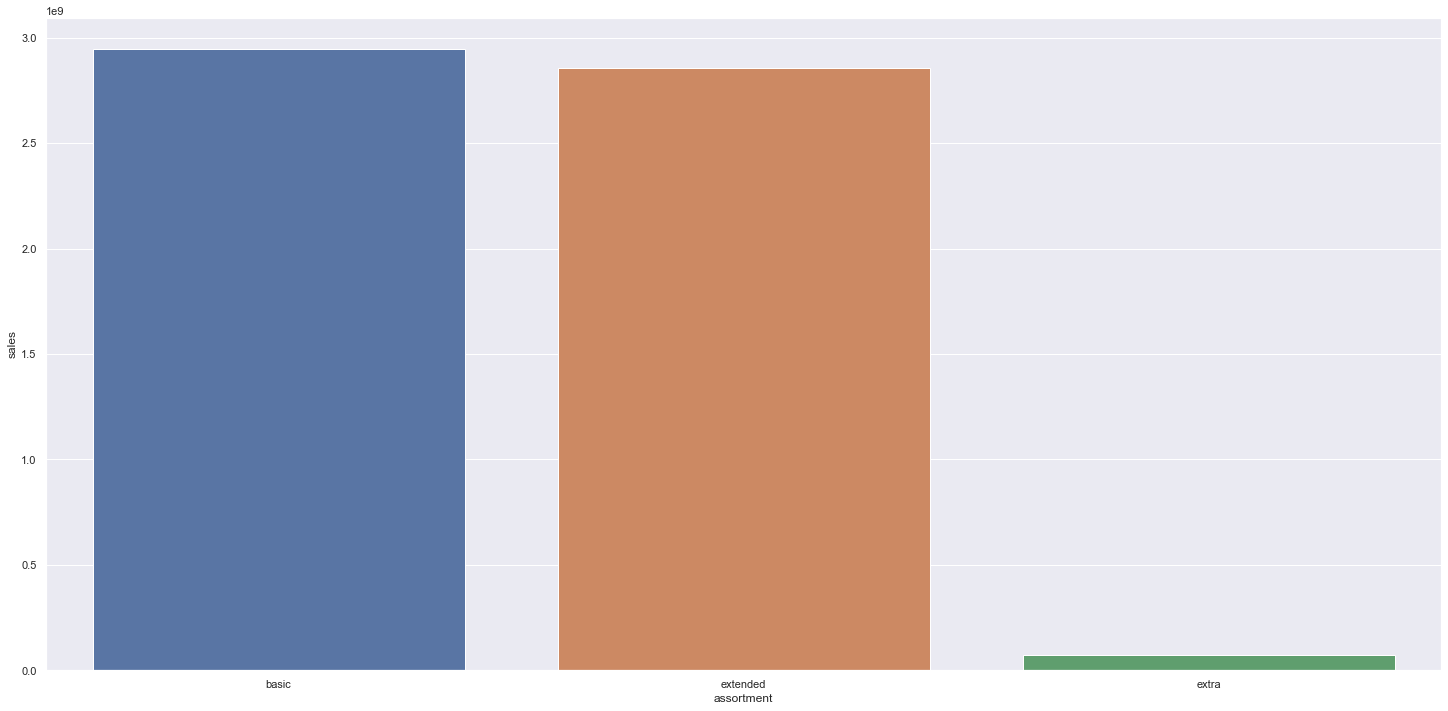

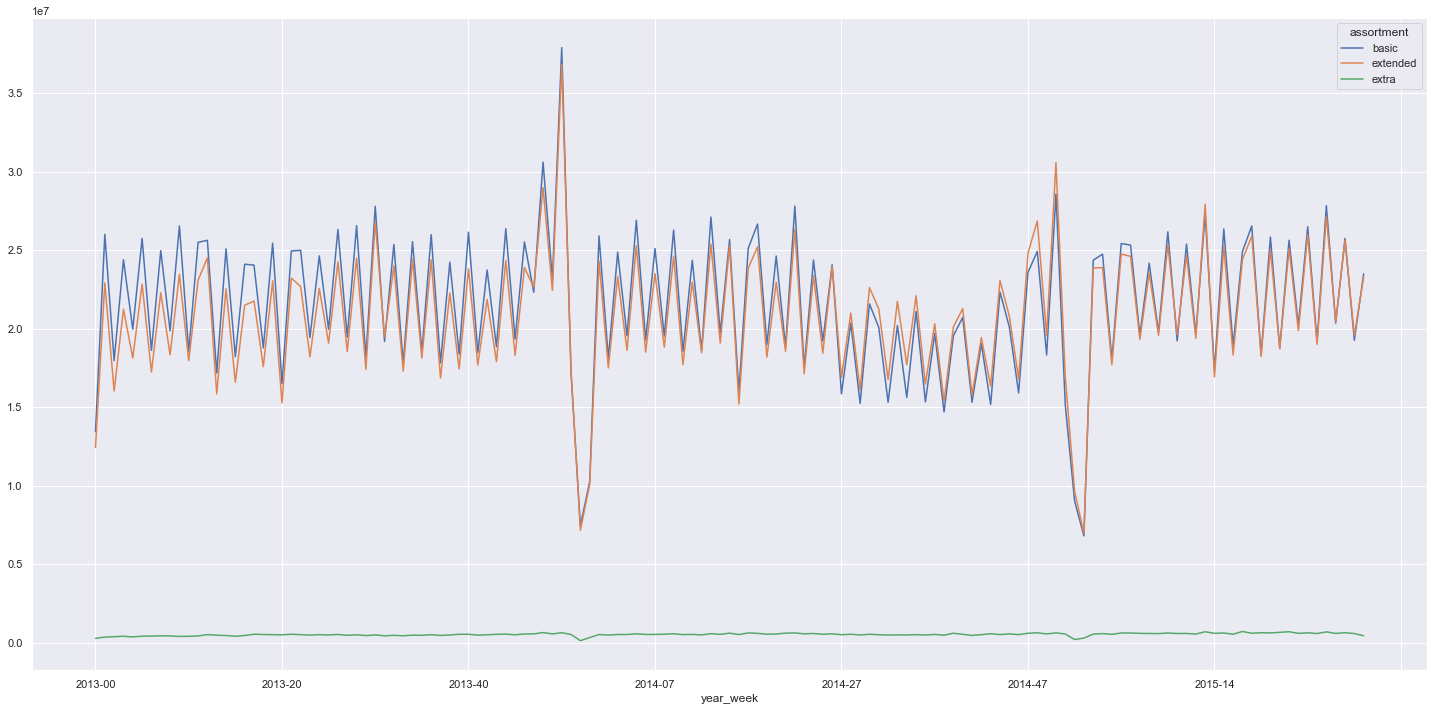

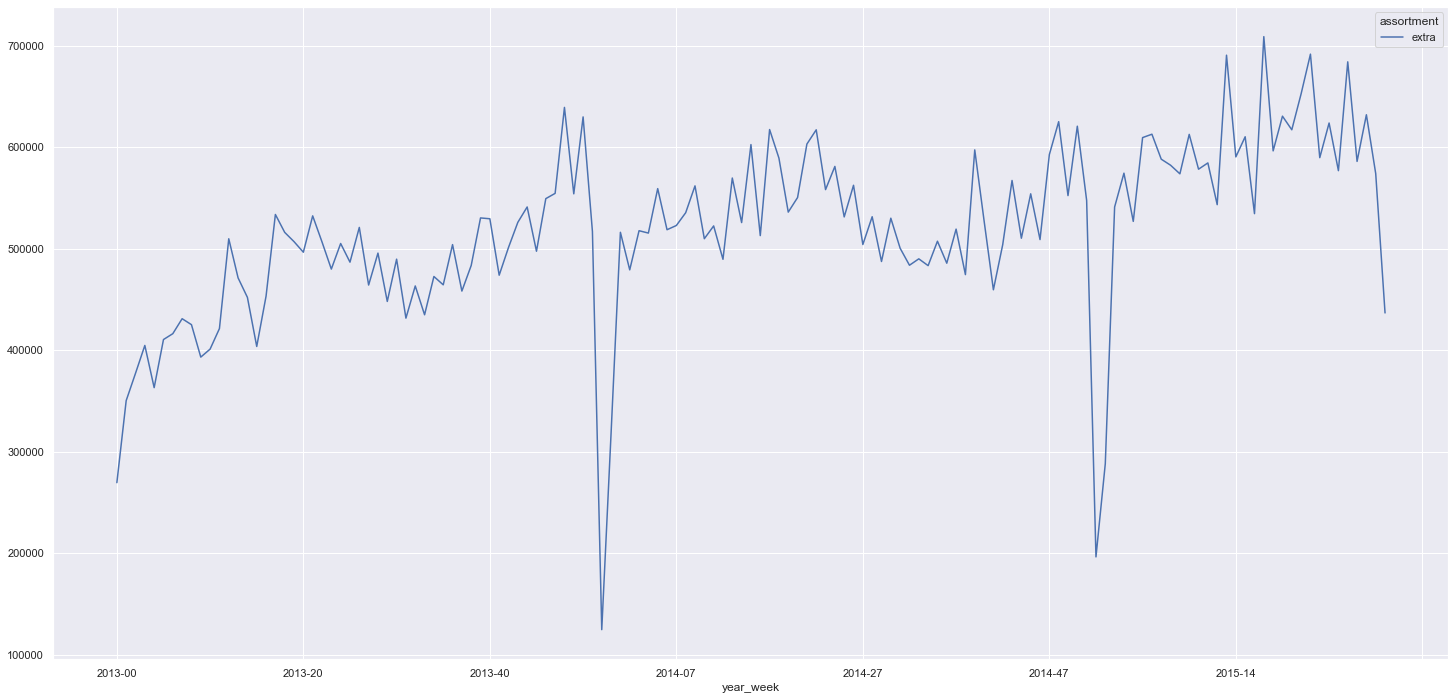

In [33]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)
aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


**H2.** Lojas com competidores mais próximos deveriam vender menos.

<AxesSubplot:>

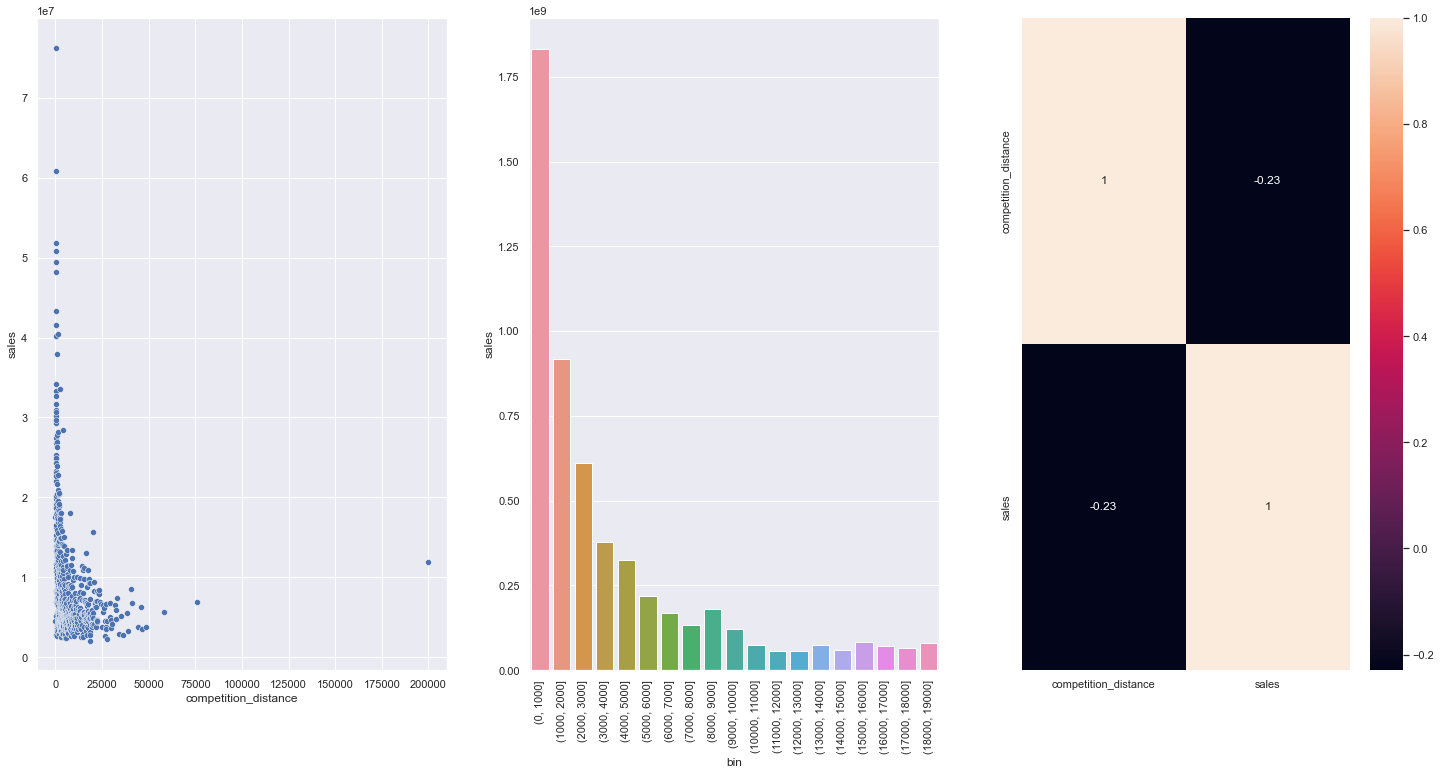

In [34]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = np.arange(0, 20000, 1000)
aux1['bin'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['bin', 'sales']].groupby('bin').sum().reset_index()
sns.barplot(x='bin', y='sales', data=aux2,)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(data=aux1.corr(method='pearson'), annot=True)


**H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

In [37]:
df4[['store', 'sales', 'state_holiday']].head(10)

,store,sales,state_holiday
0,1,5263,regular_day
1,2,6064,regular_day
2,3,8314,regular_day
3,4,13995,regular_day
4,5,4822,regular_day
5,6,5651,regular_day
6,7,15344,regular_day
7,8,8492,regular_day
8,9,8565,regular_day
9,10,7185,regular_day


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

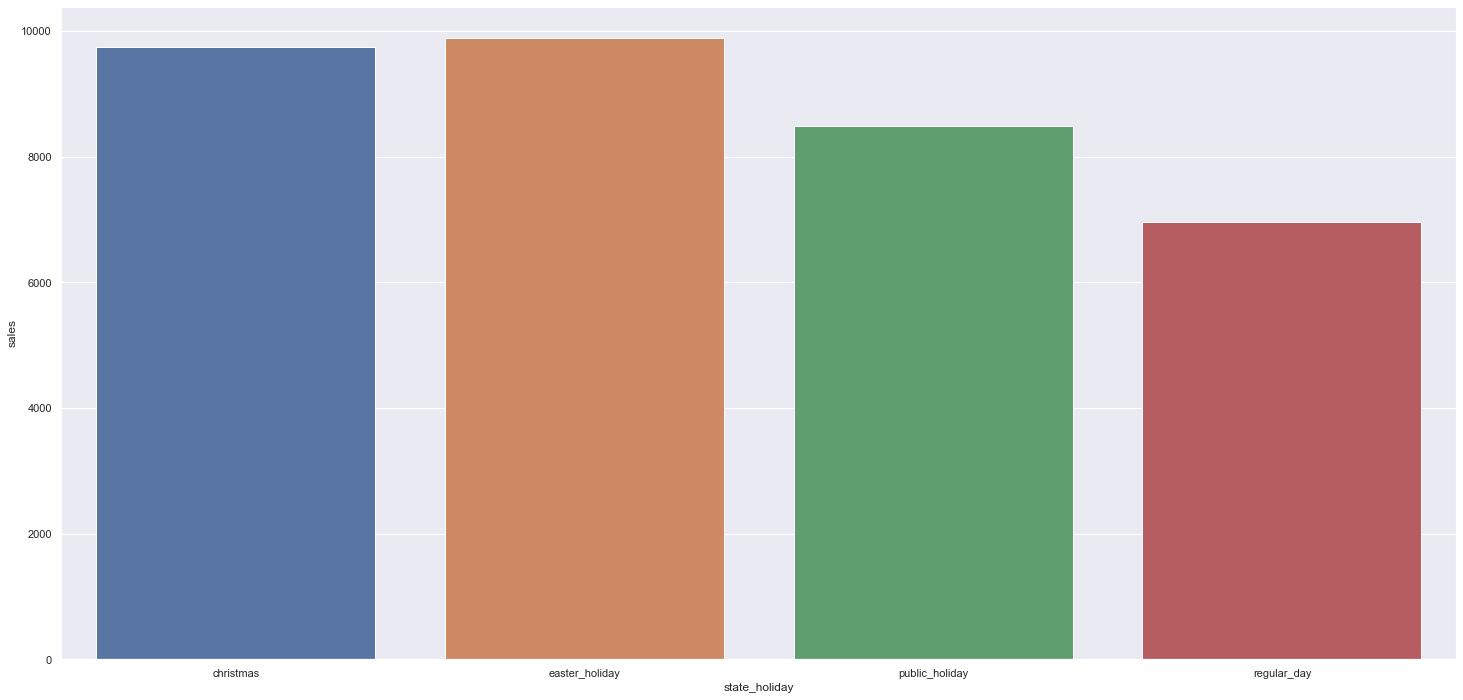

In [40]:
aux1 = df4[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 )

**9.** Lojas deveriam vender mais ao longo dos anos.

In [41]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

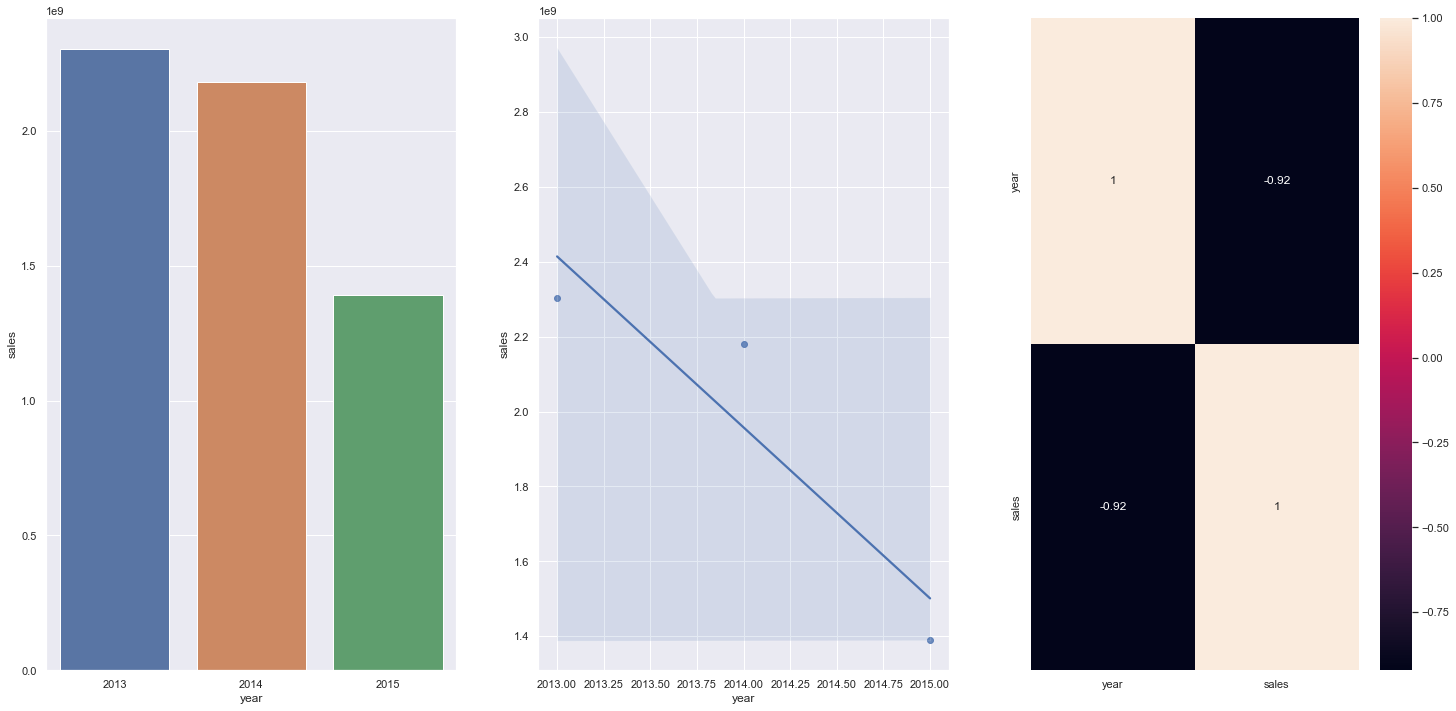

In [44]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**10.** Lojas deveriam vender mais no segundo semestre do ano.

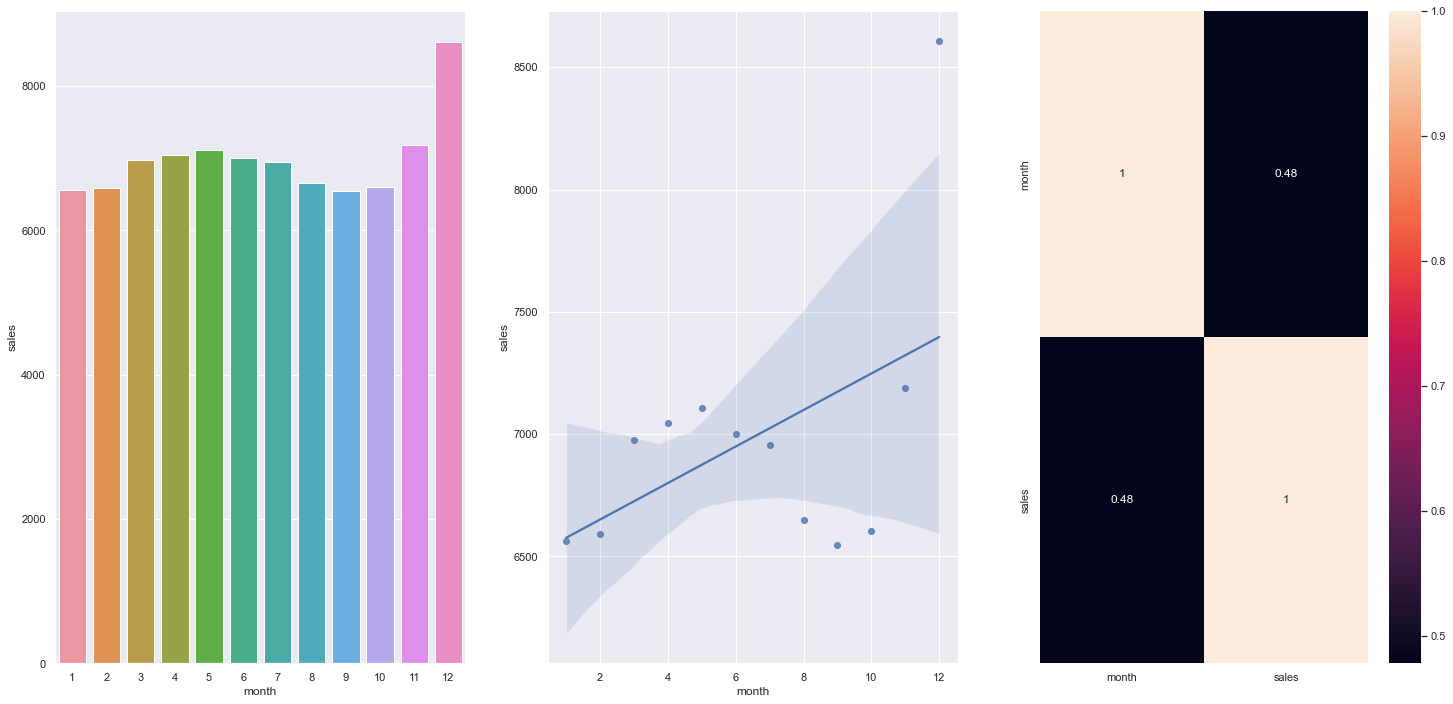

In [117]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

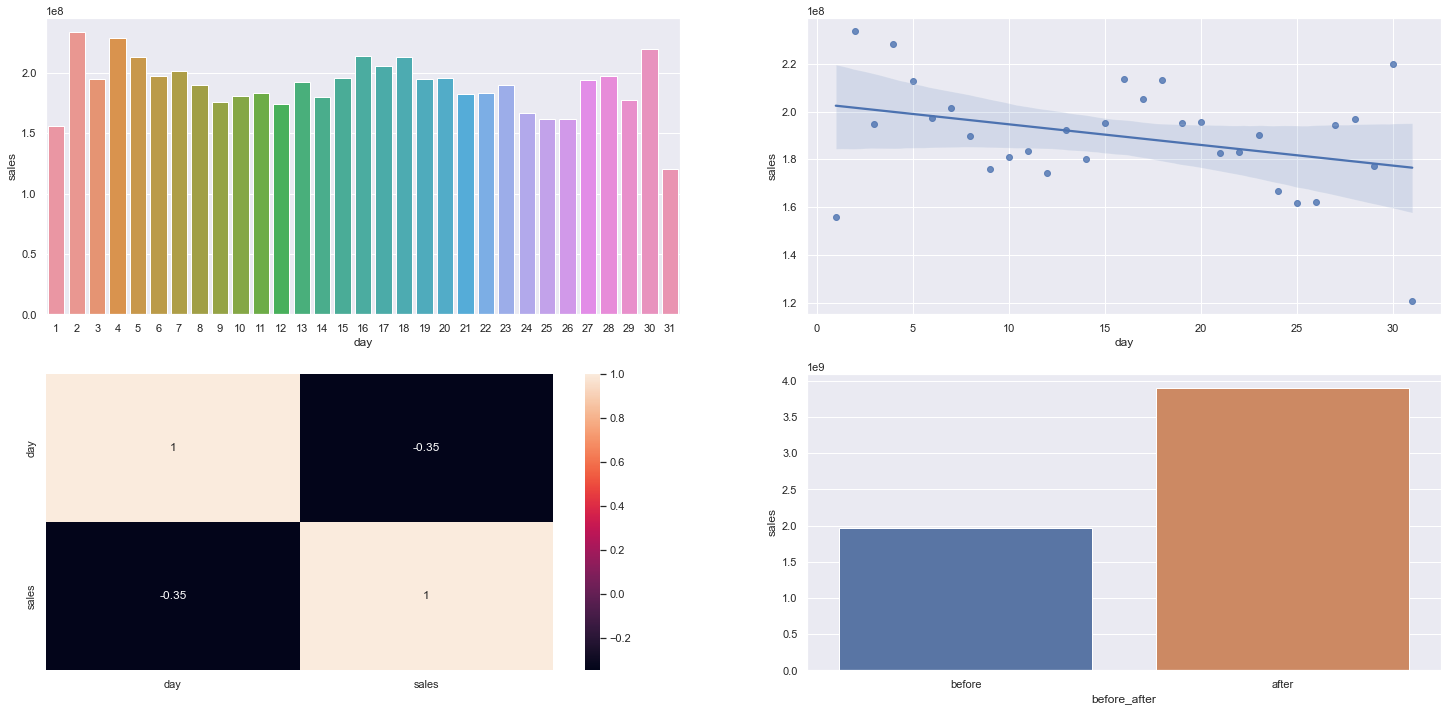

In [65]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
aux1 = aux1.assign(before_after=lambda x: pd.cut(x['day'], bins=[0,10,31], labels=['before', 'after'] ))

aux2 = aux1[['sales', 'before_after']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

**12.** Lojas deveriam vender menos aos finais de semana.

In [83]:
days = list(calendar.day_name)

i = 1
day_names = {}
while i < 8:
    day_names[i] = days[i-1]
    i = i + 1

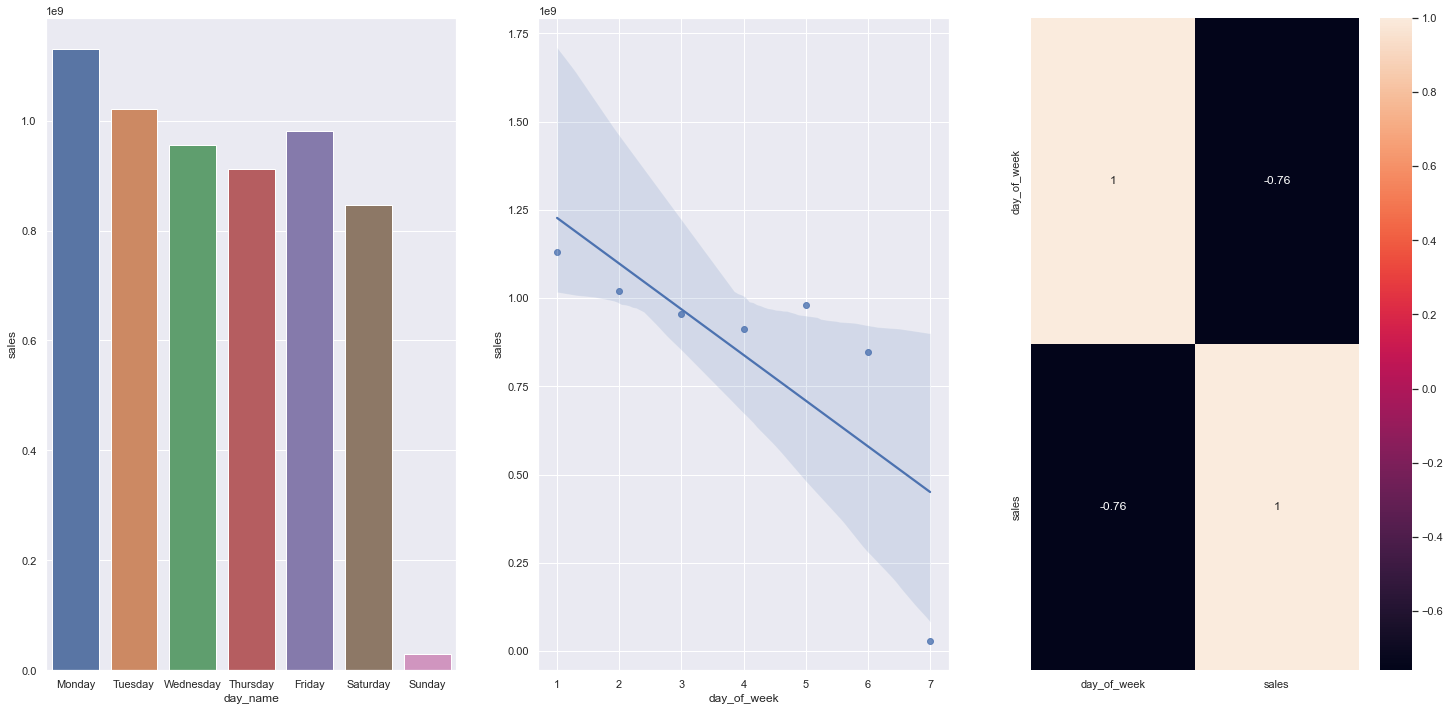

In [108]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
aux1['day_name'] = aux1['day_of_week'].map(day_names)
aux2 = aux1 [['day_name', 'sales']]

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_name', y='sales', data=aux2 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**13.** Lojas deveriam vender menos durante os feriados escolares.

<AxesSubplot:xlabel='month', ylabel='sales'>

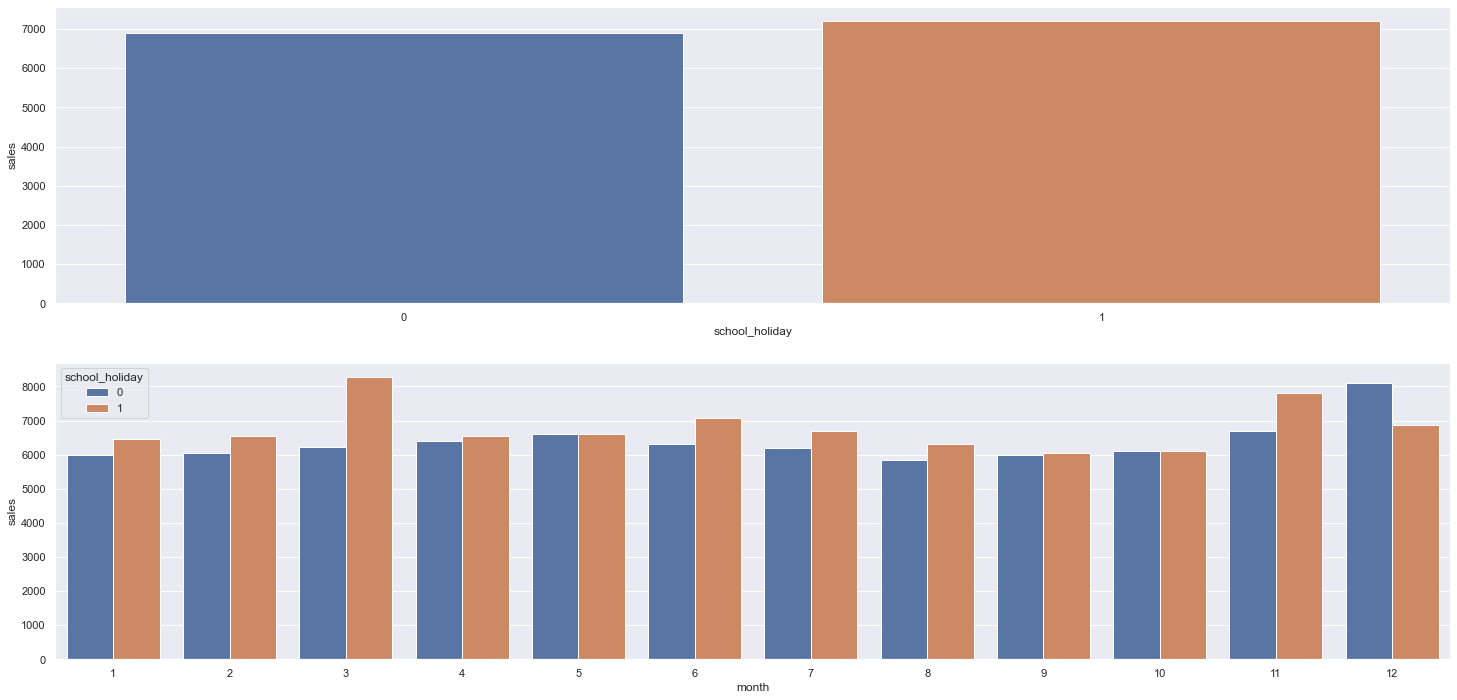

In [116]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).median().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )

In [119]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


#### 4.3 Análise Multivariada

##### 4.3.1 Variáveis Numéricas

<AxesSubplot:>

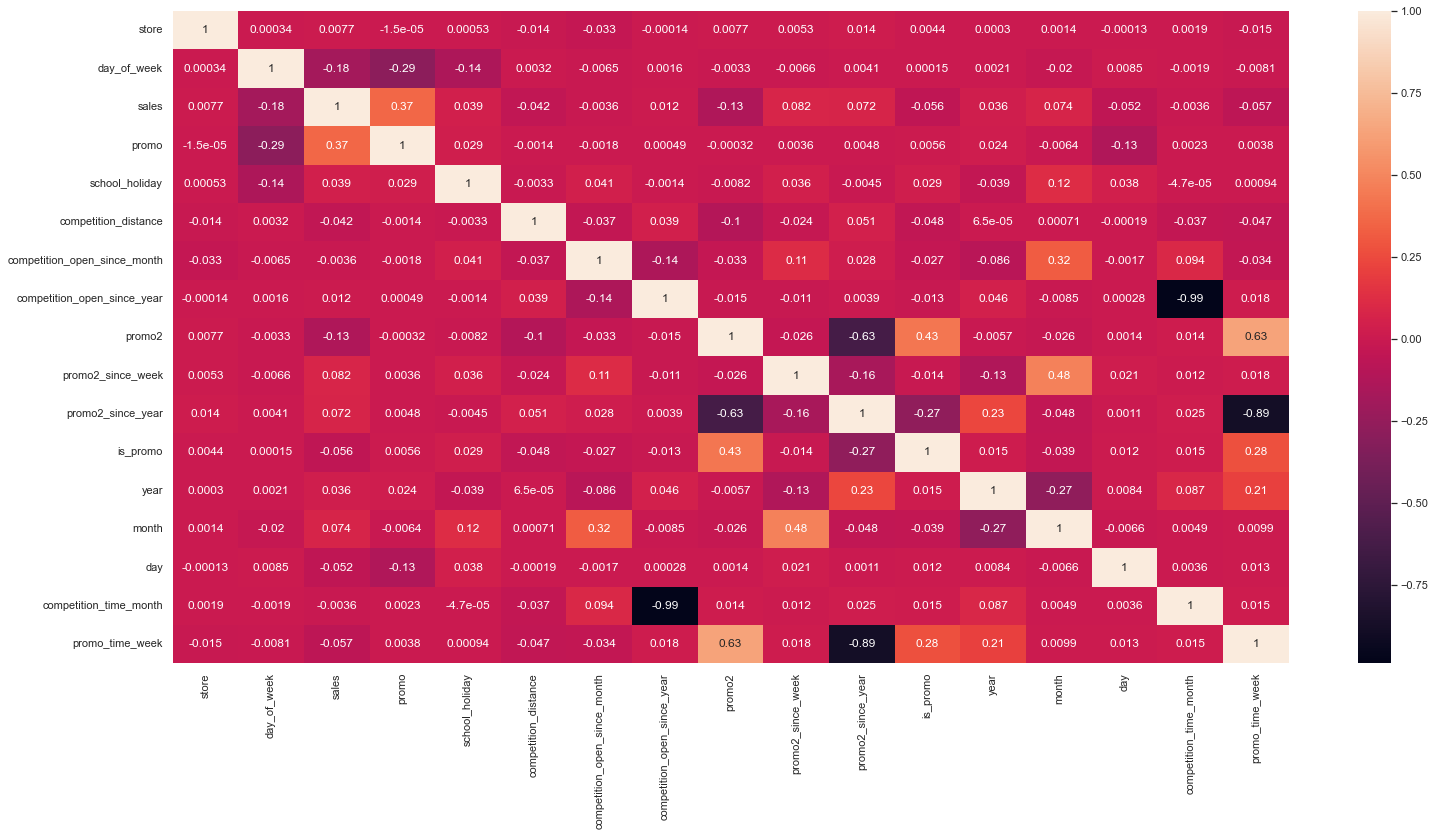

In [121]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True)

##### 4.3.2 Variáveis Categóricas

<AxesSubplot:>

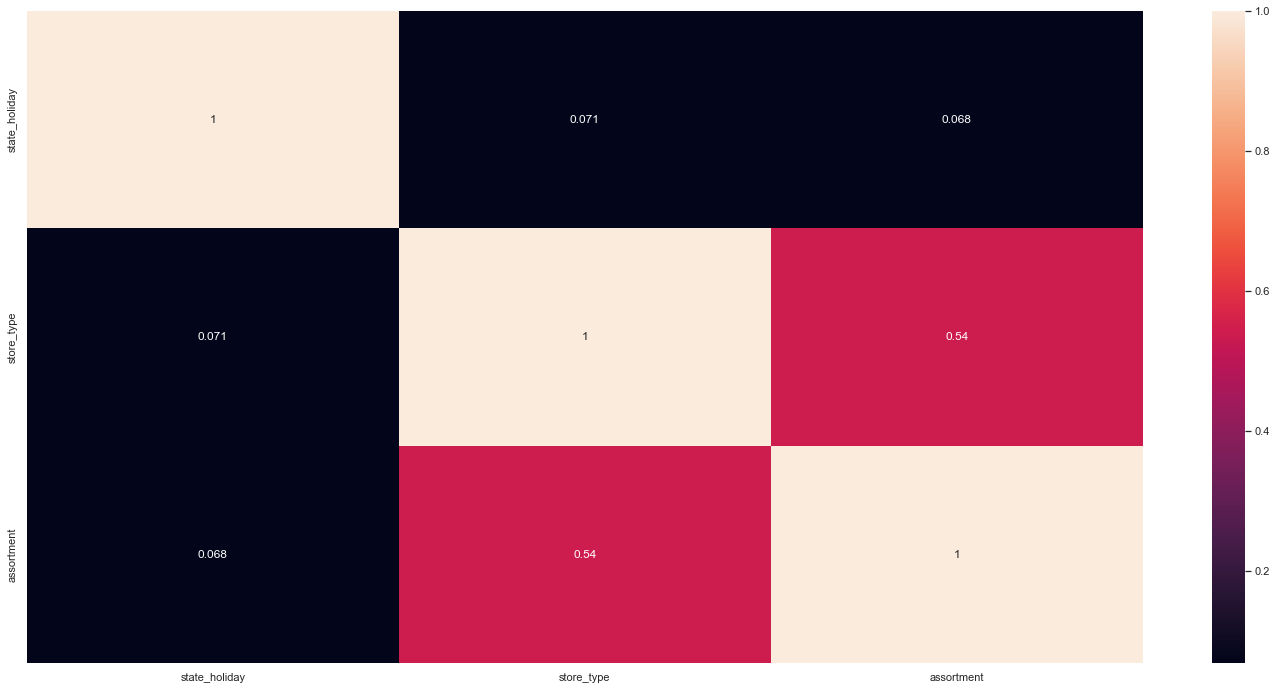

In [143]:
# only categorical data
cat_attributes = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v( cat_attributes['state_holiday'], cat_attributes['state_holiday'] )
a2 = cramer_v( cat_attributes['state_holiday'], cat_attributes['store_type'] )
a3 = cramer_v( cat_attributes['state_holiday'], cat_attributes['assortment'] )
a4 = cramer_v( cat_attributes['store_type'], cat_attributes['state_holiday'] )
a5 = cramer_v( cat_attributes['store_type'], cat_attributes['store_type'] )
a6 = cramer_v( cat_attributes['store_type'], cat_attributes['assortment'] )
a7 = cramer_v( cat_attributes['assortment'], cat_attributes['state_holiday'] )
a8 = cramer_v( cat_attributes['assortment'], cat_attributes['store_type'] )
a9 = cramer_v( cat_attributes['assortment'], cat_attributes['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

### 5. Preparação dos Dados